# Data processing
In this part we filtered out 15132 genes that are detected in less than 3 cells, and save it as whole data set((6648 cells, 17154 genes).

In [3]:
!pip install scanpy
import numpy as np
import pandas as pd
import scanpy as sc
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


/Users/haley/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 pynndescent==0.5.13


In [ ]:
maledataRR = sc.read_mtx('male.mtx')
maledataRR
femaledataRR = sc.read_mtx('female.mtx')
femaledataRR 

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.1.3.tar.gz (40.9 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [518 lines of output]
      Edit setup.cfg to change the build options
      
      BUILDING MATPLOTLIB
        matplotlib: yes [3.1.3]
            python: yes [3.9.6 (default, Mar 12 2025, 20:22:46)  [Cl

/Users/haley/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


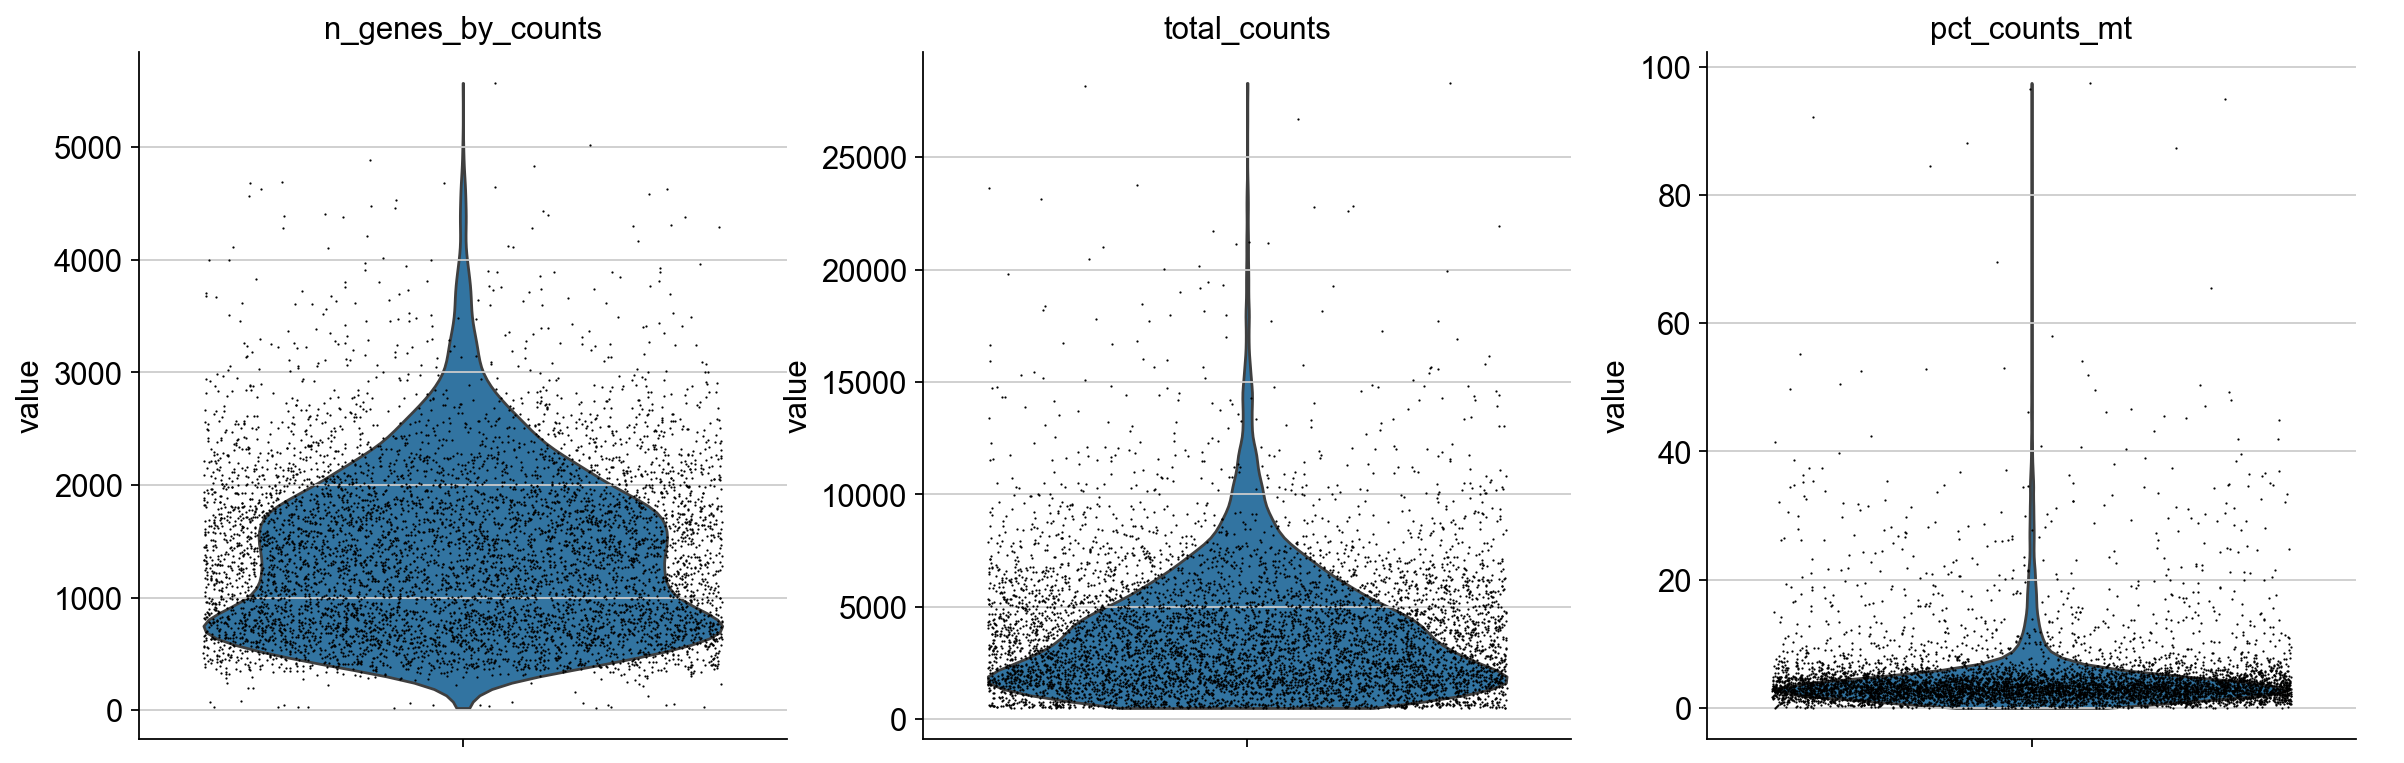

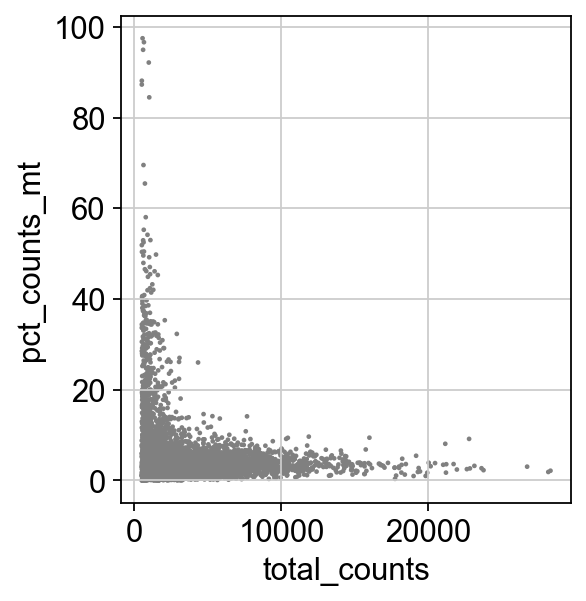

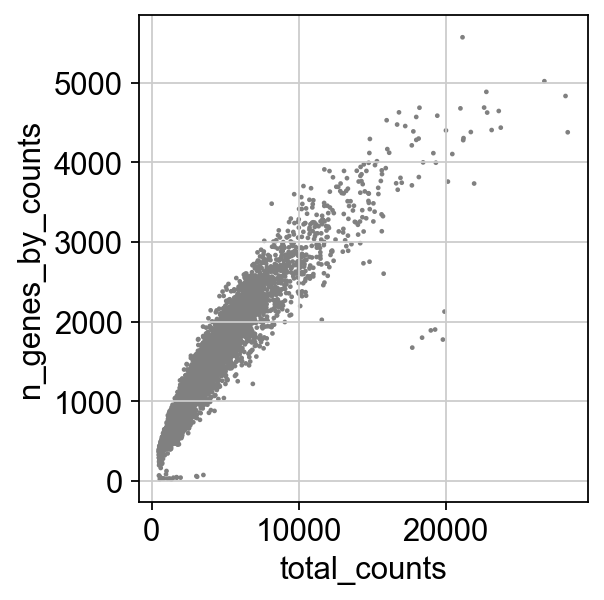

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


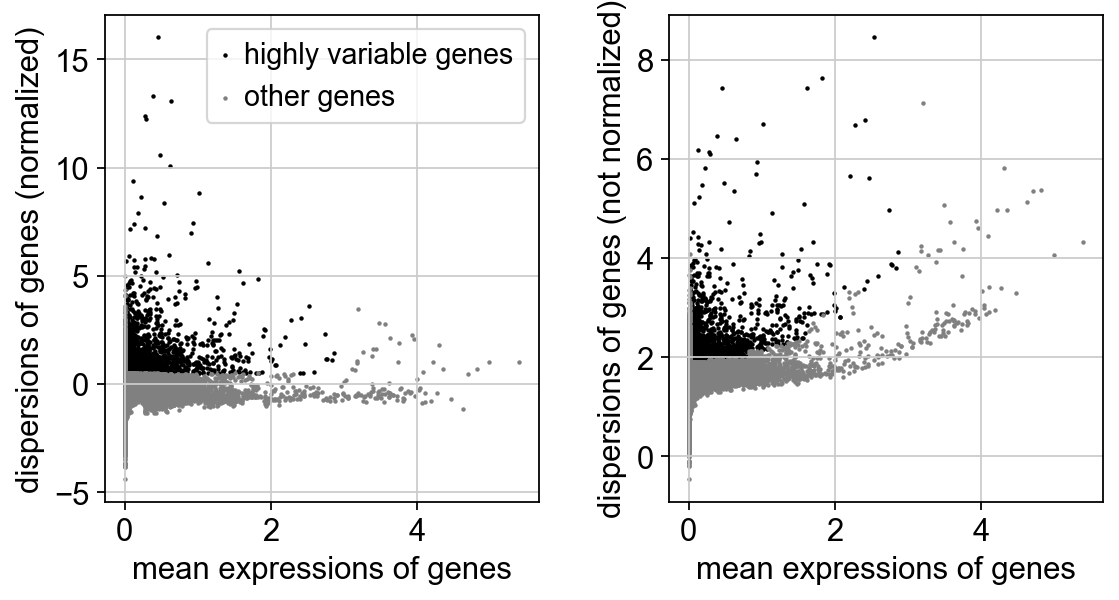

computing PCA
    with n_comps=50
    finished (0:00:02)


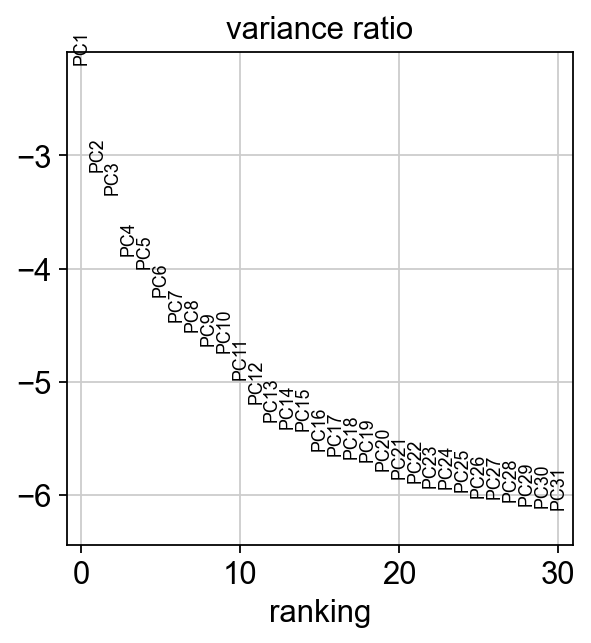

normalizing counts per cell
    finished (0:00:00)


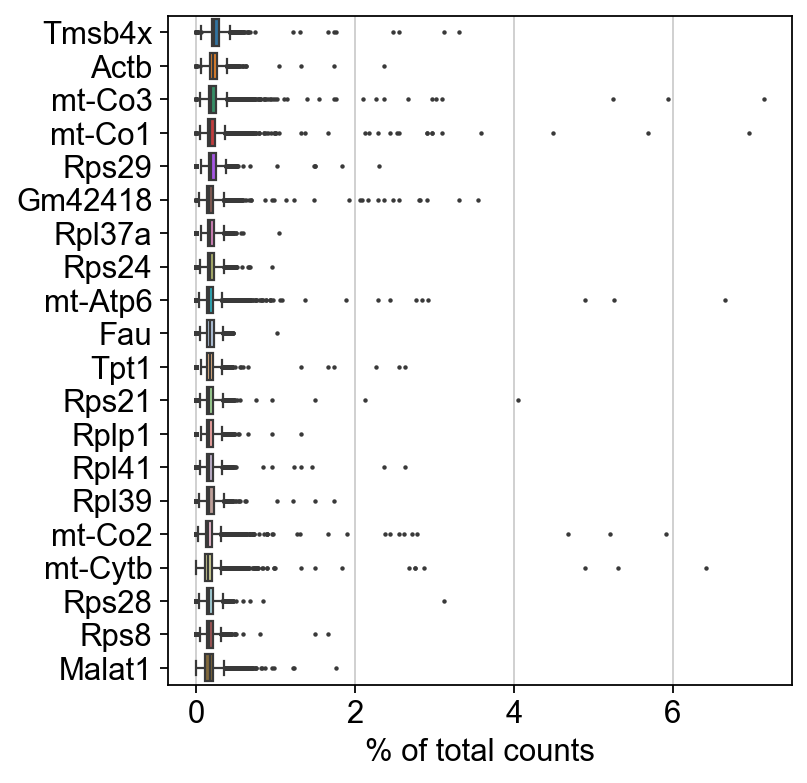

Shape of X: (6648, 17153)
Shape of Y: (6648,)


In [5]:
# ----------------------------------------------------
# (1) INSTALL AND IMPORT PACKAGES
# ----------------------------------------------------
!pip install anndata
!pip install scanpy
!pip install matplotlib==3.1.3
import numpy as np
import pandas as pd

import anndata
import scanpy as sc
import matplotlib.pyplot as plt
# ----------------------------------------------------
# (2) READ MALE AND FEMALE DATA
# ----------------------------------------------------
maledataRR = sc.read_mtx('male.mtx')
femaledataRR = sc.read_mtx('female.mtx')
fff = pd.read_csv('female.tsv', sep='\t', header=None)
mmm = pd.read_csv('male.tsv',   sep='\t', header=None)

# Combine gene info (optional)
frames = [fff, mmm]
name = pd.concat(frames, axis=0)
# Transpose so that cells become rows
femaledata = femaledataRR.T
maledata   = maledataRR.T

# Assign gene names
femaledata.var.index = fff[1]
maledata.var.index   = mmm[1]

# Give cell names
femaledata.obs_names = [f"Cell_{2685+i:d}" for i in range(femaledata.n_obs)]
maledata.obs_names   = [f"Cell_{i:d}" for i in range(maledata.n_obs)]
# Assign 'gender' to obs (just as a categorical variable)
maledata.obs["gender"]   = pd.Categorical(np.random.choice(["1"], size=(maledata.n_obs,)))

femaledata.obs["gender"] = pd.Categorical(np.random.choice(["0"], size=(femaledata.n_obs,)))

# ----------------------------------------------------
# (3) COMBINE INTO ONE AnnData (adata)
# ----------------------------------------------------
fw = femaledata.X.todense()  # female data
fr = maledata.X.todense()    # male data

x_combined = np.concatenate([fr, fw], axis=0)  # male first, female second
adata_combined = anndata.AnnData(x_combined)

# IMPORTANT: re‐assign gene names properly
index_series = fff[1].copy()
index_series.name = None
adata_combined.var.index = index_series

adata_combined.obs_names = [f"Cell_{i:d}" for i in range(adata_combined.n_obs)]

# Create 'gender' info in .obs
c11 = np.ones(maledata.n_obs)      # males
c22 = np.zeros(femaledata.n_obs)   # females
joined_list = [*c11, *c22]
adata_combined.obs["gender"] = pd.Categorical(joined_list)

# Rename final object for clarity
adata = adata_combined
adata.X = np.asarray(adata.X)

# ----------------------------------------------------
# (4) QC & FILTERING (Genes Only)
# ----------------------------------------------------
# Remove genes present in fewer than 3 cells
sc.pp.filter_genes(adata, min_cells=3) 



# Identify mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('mt-')


# Identify mitochondrial genes (human MT genes start with MT-)
 

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata.var_names_make_unique()

# Basic QC plots (optional visual checks)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

# ----------------------------------------------------
# (5) NORMALIZE & LOG
# ----------------------------------------------------
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# ----------------------------------------------------
# (6) HIGHLY VARIABLE GENES & PCA (Pre-Correction)
# ----------------------------------------------------
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# Optional quick PCA just to see variance
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

sc.pl.highest_expr_genes(adata, n_top=20)
adata.var.index.name = "n"

# ----------------------------------------------------
# (7) NO BATCH CORRECTION (Removed Scanorama Steps)
# ----------------------------------------------------
# Instead of correcting, we directly take the post-QC, post-log data for modeling

# We'll create a pandas DataFrame from adata.X
rc = pd.DataFrame(
    adata.X, 
    index=adata.obs_names, 
    columns=adata.var_names
)

# We'll store the 'gender' information as Y
rc["y"] = pd.Categorical(joined_list)

# This is our training data
training_data_ALL = rc

Y = training_data_ALL["y"]
X = training_data_ALL.drop(["y"], axis=1)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)


In [6]:
# adata.layers["log_transformed"] = np.log1p(adata.X)
#maledata.layers["log_transformed"] = np.log1p(maledata.X)

import pandas as pd
from sklearn.utils import shuffle

# Create your DataFrame
rc = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
rc["y"] = pd.Categorical(joined_list)

# Shuffle the entire DataFrame (set random_state for reproducibility if desired)
rc_shuffled = shuffle(rc, random_state=42).reset_index(drop=True)

# Now split into X and Y
Y = rc_shuffled["y"]
X = rc_shuffled.drop("y", axis=1)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)


Shape of X: (6648, 17153)
Shape of Y: (6648,)


In [7]:
rc

n,Sox17,Mrpl15,Lypla1,Tcea1,Gm16041,Atp6v1h,Rb1cc1,4732440D04Rik,St18,Pcmtd1,...,AC168977.1,CAAA01118383.1,AC132444.1,AC132444.5,Csprs,Vamp7,Tmlhe,CAAA01147332.1,AC149090.1,y
Cell_0,0.0,0.00000,1.354815,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.909851,1.0
Cell_1,0.0,0.00000,0.000000,1.223296,0.0,0.00000,0.788087,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.788087,1.0
Cell_2,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0
Cell_3,0.0,0.00000,0.000000,2.327345,0.0,0.00000,0.000000,0.0,0.0,2.327345,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,2.327345,1.0
Cell_4,0.0,0.94693,0.000000,0.946930,0.0,0.94693,0.946930,0.0,0.0,0.000000,...,0.0,0.946930,0.0,0.0,0.0,0.000000,0.0,0.0,0.946930,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell_6643,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,1.474856,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
Cell_6644,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
Cell_6645,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,1.235361,...,0.0,0.000000,0.0,0.0,0.0,1.235361,0.0,0.0,0.000000,0.0
Cell_6646,0.0,0.00000,0.000000,0.000000,0.0,0.00000,1.482703,0.0,0.0,1.482703,...,0.0,1.482703,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


# Mouse Marker Identification

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler  # Add this line


In [8]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

def evaluate_models(X, y):
    """
    Trains four models using 5-fold Stratified CV (random_state=41).
    Returns a dict of aggregated feature importances (averaged across folds).
    Shows detailed progress during execution.
    """
    print("="*60)
    print("FEATURE IMPORTANCE EVALUATION")
    print("="*60)
    print(f"Dataset shape: {X.shape}")
    print(f"Target distribution: {y.value_counts().to_dict()}")
    print(f"Starting evaluation at: {datetime.now().strftime('%H:%M:%S')}")
    print()
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=41)
    
    # Define models, all using random_state=41 where applicable
    models = [
        LogisticRegression(max_iter=1000, random_state=41),
        SVC(kernel='linear', probability=True, random_state=41),
        XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            n_estimators=100,
            learning_rate=0.05,
            max_depth=10,
            random_state=41
        ),
        RandomForestClassifier(max_depth=10, random_state=41)
    ]

    model_names = [type(model).__name__ for model in models]
    print(f"Models to evaluate: {', '.join(model_names)}")
    print(f"Total training iterations: {len(models)} models × 5 folds = {len(models) * 5}")
    print()

    # For each model, we'll store feature importances from each fold in a list
    importance_dfs = {type(model).__name__: [] for model in models}

    # 5-fold CV with progress tracking
    total_iterations = 0
    max_iterations = len(models) * 5
    
    for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        print(f"📁 FOLD {fold_idx}/5")
        print(f"   Train samples: {len(train_index)}, Test samples: {len(test_index)}")
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Scale training and test data
        print("   📊 Scaling features...")
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Fit each model, collect feature importances
        for model_idx, model in enumerate(models, 1):
            total_iterations += 1
            model_name = type(model).__name__
            
            print(f"   🤖 Training {model_name} ({model_idx}/{len(models)}) "
                  f"[Overall: {total_iterations}/{max_iterations}]")
            
            # Train the model
            model.fit(X_train_scaled, y_train)

            # Grab feature importances from different model types
            if hasattr(model, 'coef_'):
                # For linear models (LogisticRegression, linear SVC),
                # we take absolute value of coefficients
                importances = np.abs(model.coef_[0])
                importance_type = "coefficients"
            elif hasattr(model, 'feature_importances_'):
                # For tree-based models (RF, XGB),
                # we can use .feature_importances_
                importances = model.feature_importances_
                importance_type = "feature_importances"
            else:
                # Default (just in case)
                importances = np.zeros(X_train.shape[1])
                importance_type = "zeros (fallback)"
            
            print(f"      ✓ Extracted {importance_type}, top importance: {importances.max():.4f}")
            
            # Create a DataFrame of features and their importances
            feature_df = pd.DataFrame({
                'Feature': X.columns,
                'Importance': importances
            })
            importance_dfs[model_name].append(feature_df)
        
        print(f"   ✅ Fold {fold_idx} completed")
        print()

    print("🔄 AGGREGATING RESULTS ACROSS FOLDS...")
    print()

    # Aggregate feature importances across the 5 folds for each model
    aggregated_importances = {}
    for model_idx, (model_name, dfs) in enumerate(importance_dfs.items(), 1):
        print(f"📈 Processing {model_name} ({model_idx}/{len(importance_dfs)})...")
        
        # Combine importances from all folds
        all_importances = pd.concat(dfs)
        print(f"   Combined {len(dfs)} fold results")
        
        # Group by feature, compute mean importance
        feature_importance_mean = (all_importances
                                   .groupby('Feature')['Importance']
                                   .mean()
                                   .reset_index())

        # Sort descending by mean importance
        feature_importance_mean = feature_importance_mean.sort_values(
            by='Importance', ascending=False
        ).reset_index(drop=True)

        # Create a "Rank" column (1 = most important)
        feature_importance_mean['Rank'] = feature_importance_mean['Importance'].rank(
            method='dense', ascending=False
        ).astype(int)

        aggregated_importances[model_name] = feature_importance_mean
        
        # Show top 3 features for this model
        top_features = feature_importance_mean.head(3)
        print(f"   Top 3 features:")
        for _, row in top_features.iterrows():
            print(f"     {row['Rank']}. {row['Feature']}: {row['Importance']:.4f}")
        print()

    print("✅ ALL MODELS COMPLETED!")
    print(f"Evaluation finished at: {datetime.now().strftime('%H:%M:%S')}")
    print()
    
    return aggregated_importances


# Example usage (assuming you have X, Y DataFrames or Series):
print("🚀 Starting feature importance analysis...")
aggregated_importances = evaluate_models(X, Y)

print("💾 SAVING RESULTS...")
# Create a subdirectory for the output
output_dir = "feature_importance_mar_29"
os.makedirs(output_dir, exist_ok=True)
print(f"Created directory: {output_dir}")

# Save each model's results to a CSV in the new directory
for model_name, data in aggregated_importances.items():
    file_path = os.path.join(output_dir, f"{model_name}_feature_importances.csv")
    data.to_csv(file_path, index=False)
    print(f"✓ Saved: {file_path} ({len(data)} features)")

print()
print("🎉 ANALYSIS COMPLETE!")
print(f"Feature importance CSVs saved in '{output_dir}' directory.")
print("="*60)

🚀 Starting feature importance analysis...
FEATURE IMPORTANCE EVALUATION
Dataset shape: (6648, 17153)
Target distribution: {0.0: 3963, 1.0: 2685}
Starting evaluation at: 01:37:36

Models to evaluate: LogisticRegression, SVC, XGBClassifier, RandomForestClassifier
Total training iterations: 4 models × 5 folds = 20

📁 FOLD 1/5
   Train samples: 5318, Test samples: 1330
   📊 Scaling features...
   🤖 Training LogisticRegression (1/4) [Overall: 1/20]
      ✓ Extracted coefficients, top importance: 1.1206
   🤖 Training SVC (2/4) [Overall: 2/20]
      ✓ Extracted coefficients, top importance: 0.1444
   🤖 Training XGBClassifier (3/4) [Overall: 3/20]


/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [07:33:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


      ✓ Extracted feature_importances, top importance: 0.0549
   🤖 Training RandomForestClassifier (4/4) [Overall: 4/20]
      ✓ Extracted feature_importances, top importance: 0.0540
   ✅ Fold 1 completed

📁 FOLD 2/5
   Train samples: 5318, Test samples: 1330
   📊 Scaling features...
   🤖 Training LogisticRegression (1/4) [Overall: 5/20]
      ✓ Extracted coefficients, top importance: 1.1316
   🤖 Training SVC (2/4) [Overall: 6/20]
      ✓ Extracted coefficients, top importance: 0.1456
   🤖 Training XGBClassifier (3/4) [Overall: 7/20]


/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [11:59:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


      ✓ Extracted feature_importances, top importance: 0.0549
   🤖 Training RandomForestClassifier (4/4) [Overall: 8/20]
      ✓ Extracted feature_importances, top importance: 0.0748
   ✅ Fold 2 completed

📁 FOLD 3/5
   Train samples: 5318, Test samples: 1330
   📊 Scaling features...
   🤖 Training LogisticRegression (1/4) [Overall: 9/20]
      ✓ Extracted coefficients, top importance: 1.1084
   🤖 Training SVC (2/4) [Overall: 10/20]
      ✓ Extracted coefficients, top importance: 0.1439
   🤖 Training XGBClassifier (3/4) [Overall: 11/20]


/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [12:43:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


      ✓ Extracted feature_importances, top importance: 0.0557
   🤖 Training RandomForestClassifier (4/4) [Overall: 12/20]
      ✓ Extracted feature_importances, top importance: 0.0729
   ✅ Fold 3 completed

📁 FOLD 4/5
   Train samples: 5319, Test samples: 1329
   📊 Scaling features...
   🤖 Training LogisticRegression (1/4) [Overall: 13/20]
      ✓ Extracted coefficients, top importance: 1.1267
   🤖 Training SVC (2/4) [Overall: 14/20]
      ✓ Extracted coefficients, top importance: 0.1437
   🤖 Training XGBClassifier (3/4) [Overall: 15/20]


/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:37:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


      ✓ Extracted feature_importances, top importance: 0.0523
   🤖 Training RandomForestClassifier (4/4) [Overall: 16/20]
      ✓ Extracted feature_importances, top importance: 0.0569
   ✅ Fold 4 completed

📁 FOLD 5/5
   Train samples: 5319, Test samples: 1329
   📊 Scaling features...
   🤖 Training LogisticRegression (1/4) [Overall: 17/20]
      ✓ Extracted coefficients, top importance: 1.1206
   🤖 Training SVC (2/4) [Overall: 18/20]
      ✓ Extracted coefficients, top importance: 0.1429
   🤖 Training XGBClassifier (3/4) [Overall: 19/20]


/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [15:21:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


      ✓ Extracted feature_importances, top importance: 0.0522
   🤖 Training RandomForestClassifier (4/4) [Overall: 20/20]
      ✓ Extracted feature_importances, top importance: 0.0511
   ✅ Fold 5 completed

🔄 AGGREGATING RESULTS ACROSS FOLDS...

📈 Processing LogisticRegression (1/4)...
   Combined 5 fold results
   Top 3 features:
     1. Xist: 1.1216
     2. Ddx3y: 0.5086
     3. Eif2s3y: 0.4748

📈 Processing SVC (2/4)...
   Combined 5 fold results
   Top 3 features:
     1. Xist: 0.1441
     2. Gm42418: 0.0661
     3. Ddx3y: 0.0587

📈 Processing XGBClassifier (3/4)...
   Combined 5 fold results
   Top 3 features:
     1. Xist: 0.0540
     2. Ddx3y: 0.0032
     3. Malat1: 0.0025

📈 Processing RandomForestClassifier (4/4)...
   Combined 5 fold results
   Top 3 features:
     1. Xist: 0.0620
     2. Ddx3y: 0.0186
     3. Gm42418: 0.0140

✅ ALL MODELS COMPLETED!
Evaluation finished at: 15:22:07

💾 SAVING RESULTS...
Created directory: feature_importance_mar_29
✓ Saved: feature_importance_

In [60]:
import os
import pandas as pd

def load_importances_from_dir(dir_path: str) -> dict[str, pd.DataFrame]:
    """
    Read all CSVs produced by `evaluate_models` into a dict keyed by model name.
    Each CSV must be named '<ModelName>_feature_importances.csv'.
    """
    agg = {}
    for fname in os.listdir(dir_path):
        if fname.endswith("_feature_importances.csv"):
            model_name = fname.replace("_feature_importances.csv", "")
            fpath = os.path.join(dir_path, fname)
            agg[model_name] = pd.read_csv(fpath)
    if not agg:
        raise FileNotFoundError(f"No CSVs ending in '_feature_importances.csv' found in {dir_path}")
    return agg


def majority_vote_top_features_from_dir(
    dir_path: str,
    top_k: int = 20,
    min_models: int = 3
) -> pd.DataFrame:
    """
    Wrapper that loads the CSVs *and* performs majority-voting.

    Parameters
    ----------
    dir_path   : folder containing '<ModelName>_feature_importances.csv'.
    top_k      : how many top features to take from each model.
    min_models : keep features that appear in at least this many models.
    """
    aggregated_importances = load_importances_from_dir(dir_path)

    # ────────── ORIGINAL MAJORITY-VOTE LOGIC ────────── #
    top_features_per_model = {}
    for model_name, df in aggregated_importances.items():
        df_sorted = df.sort_values("Importance", ascending=False, ignore_index=True)
        top_k_df  = df_sorted.head(top_k).copy()
        top_k_df["Importance_Norm"] = top_k_df["Importance"] / top_k_df["Importance"].sum()
        top_features_per_model[model_name] = top_k_df

    # merge on 'Feature'
    merged = None
    for model_name, df_top in top_features_per_model.items():
        df_renamed = df_top[['Feature', 'Importance', 'Importance_Norm']].rename(
            columns={
                'Importance':      f"{model_name}_Importance",
                'Importance_Norm': f"{model_name}_Norm"
            }
        )
        merged = df_renamed if merged is None else merged.merge(df_renamed, on="Feature", how="outer")

    model_names = list(top_features_per_model.keys())
    merged["AppearCount"] = sum(merged[f"{m}_Importance"].notna() for m in model_names)

    # keep only features in ≥ min_models models
    merged = merged[merged["AppearCount"] >= min_models].copy()

    # replace NaNs with 0 for norm columns, then sum
    for m in model_names:
        merged[f"{m}_Norm"] = merged[f"{m}_Norm"].fillna(0.0)
    merged["CombinedNorm"] = merged[[f"{m}_Norm" for m in model_names]].sum(axis=1)

    merged.sort_values("CombinedNorm", ascending=False, inplace=True)
    return merged.reset_index(drop=True)


# ────────── EXAMPLE USAGE ──────────
DIR = "feature_importance_mar_29"          # change if you used a different folder
majority_df = majority_vote_top_features_from_dir(DIR, top_k=20, min_models=3)

print("\nTop features that appear in at least 3 of 4 models’ top-20 lists:")
print(majority_df)



Top features that appear in at least 3 of 4 models’ top-20 lists:
       Feature  RandomForestClassifier_Importance  \
0         Xist                           0.061953   
1        Ddx3y                           0.018598   
2      Gm42418                           0.014018   
3      Eif2s3y                           0.014004   
4      Rps27rt                           0.007783   
5     Rpl9-ps6                           0.005505   
6        Kdm5d                           0.007446   
7        Uba52                           0.005363   
8        Rpl35                           0.004644   
9   Rpl36a-ps1                           0.004340   
10         Uty                           0.004611   
11       Wdr89                           0.003505   
12       Lars2                           0.004394   
13       Rps27                           0.004715   

    RandomForestClassifier_Norm  XGBClassifier_Importance  XGBClassifier_Norm  \
0                      0.345953                  0.05401

Loaded data shape: (43, 9)
Columns: ['Gene', 'RandomForestClassifier_Norm', 'XGBClassifier_Norm', 'SVC_Norm', 'LogisticRegression_Norm', 'AppearCount', 'CombinedNorm', 'BonusPenalty', 'FinalScore']

First few rows:
      Gene  RandomForestClassifier_Norm  XGBClassifier_Norm  SVC_Norm  \
0     Xist                     0.345953            0.639457  0.168420   
1    Ddx3y                     0.103855            0.038215  0.068610   
2  Gm42418                     0.078278            0.023183  0.077267   
3  Eif2s3y                     0.078198            0.022737  0.067095   
4    Rpl35                     0.025932            0.025711  0.035984   

   LogisticRegression_Norm  AppearCount  CombinedNorm  BonusPenalty  \
0                 0.170605            4      1.324435           1.0   
1                 0.077364            4      0.288044           1.0   
2                 0.071942            4      0.250669           1.0   
3                 0.072215            4      0.240246         

/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_2304/4188162359.py:137: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


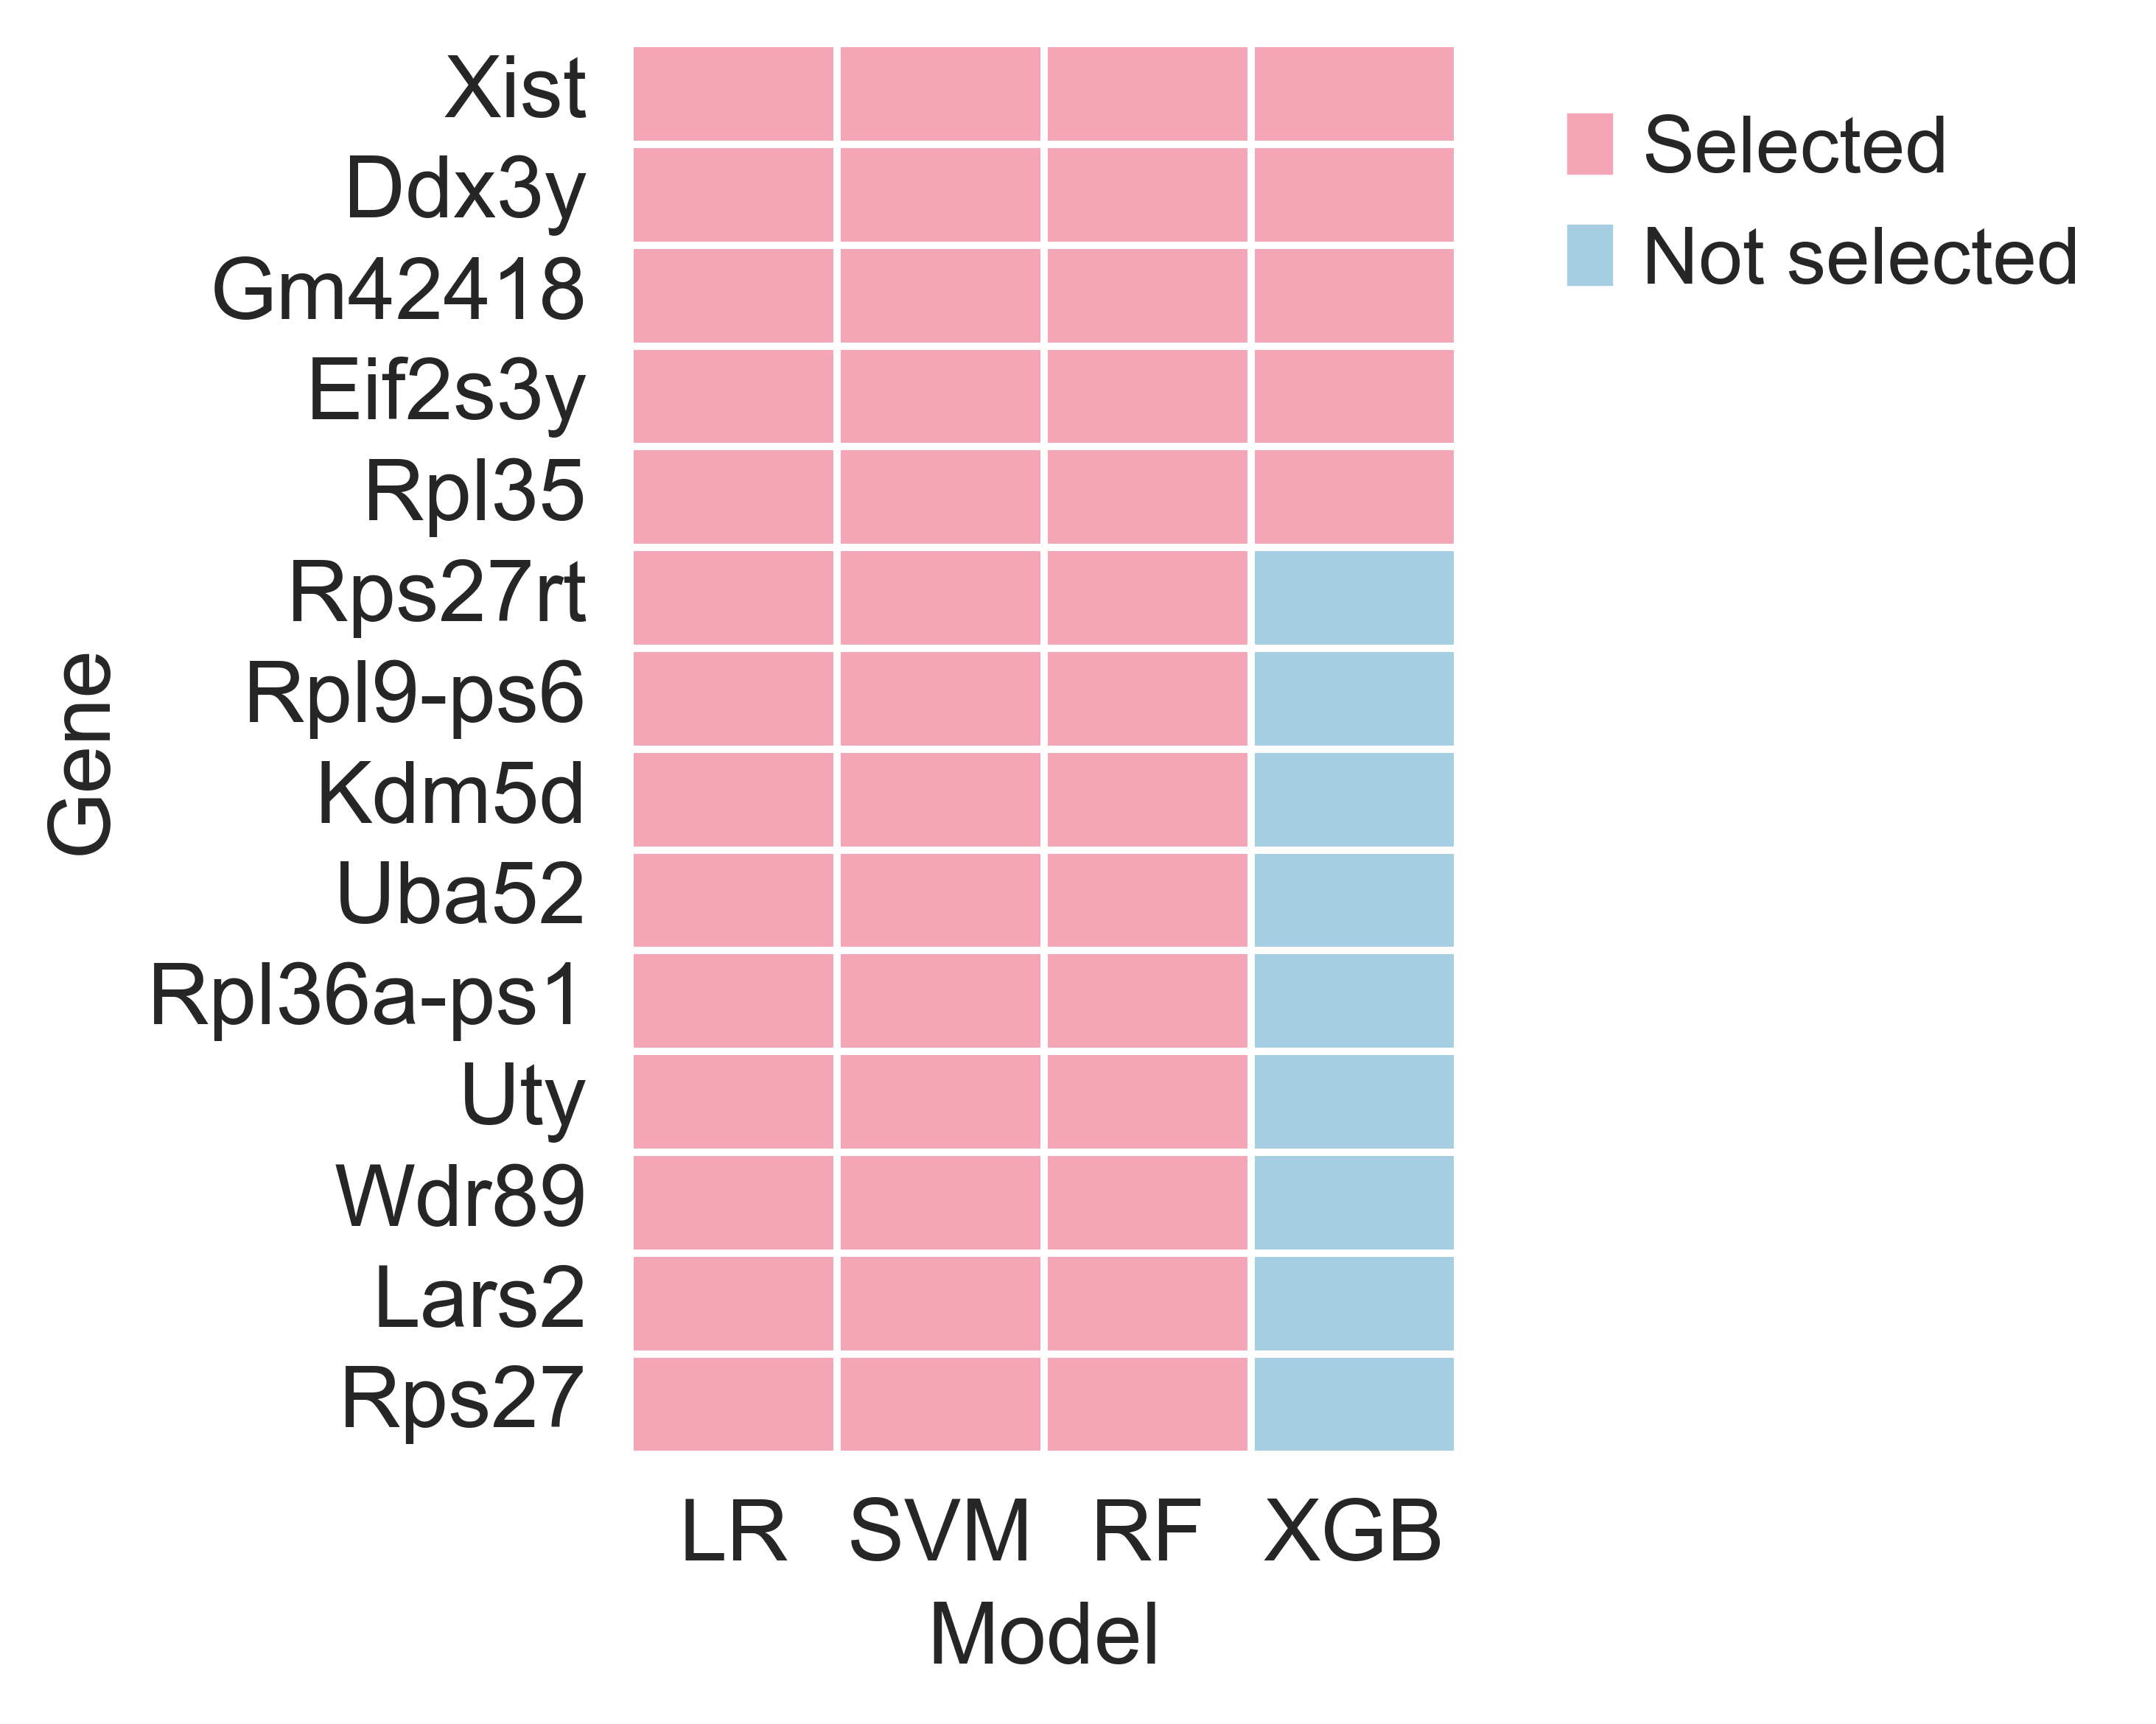


HEATMAP SUMMARY
Models included: ['LR', 'SVM', 'RF', 'XGB']
Scoring: FinalScore = CombinedNorm + 0.25*(2*AppearCount - 4)

Top 14 gene selections:
 1. Xist        : 4/4 models (2.3244) - LR, SVM, RF, XGB
 2. Ddx3y       : 4/4 models (1.2880) - LR, SVM, RF, XGB
 3. Gm42418     : 4/4 models (1.2507) - LR, SVM, RF, XGB
 4. Eif2s3y     : 4/4 models (1.2402) - LR, SVM, RF, XGB
 5. Rpl35       : 4/4 models (1.1218) - LR, SVM, RF, XGB
 6. Rps27rt     : 3/4 models (0.6500) - LR, SVM, RF
 7. Rpl9-ps6    : 3/4 models (0.6364) - LR, SVM, RF
 8. Kdm5d       : 3/4 models (0.6268) - LR, SVM, RF
 9. Uba52       : 3/4 models (0.6238) - LR, SVM, RF
10. Rpl36a-ps1  : 3/4 models (0.6151) - LR, SVM, RF
11. Uty         : 3/4 models (0.6034) - LR, SVM, RF
12. Wdr89       : 3/4 models (0.6020) - LR, SVM, RF
13. Lars2       : 3/4 models (0.6007) - LR, SVM, RF
14. Rps27       : 3/4 models (0.5999) - LR, SVM, RF


In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ── 1. Load the data from your CSV file ─────────────────────────────────────
OUT_CSV = "/Users/haley/Desktop/send_tooo/AAA_final/marker_rank/marker_rank_union_scores.csv"
features_df = pd.read_csv(OUT_CSV)

print("Loaded data shape:", features_df.shape)
print("Columns:", features_df.columns.tolist())
print("\nFirst few rows:")
print(features_df.head())

# ── 2. Automatically detect model columns ───────────────────────────────────
# Find all columns ending with "_Norm" (these are your model columns)
model_cols = [col for col in features_df.columns if col.endswith('_Norm')]
print(f"\nDetected model columns: {model_cols}")

# ── 3. Verify/recalculate the penalty-based scoring algorithm ─────────────────
M = len(model_cols)  # number of models
print(f"Number of models (M): {M}")

# Recalculate to ensure consistency
features_df_calc = features_df.copy()
features_df_calc["AppearCount_check"] = features_df_calc[model_cols].apply(lambda row: (row > 0).sum(), axis=1)
features_df_calc["CombinedNorm_check"] = features_df_calc[model_cols].sum(axis=1)
features_df_calc["BonusPenalty_check"] = 0.25 * (2 * features_df_calc["AppearCount_check"] - M)
features_df_calc["FinalScore_check"] = features_df_calc["CombinedNorm_check"] + features_df_calc["BonusPenalty_check"]

print(f"\nScoring algorithm verification:")
print(f"FinalScore = CombinedNorm + BonusPenalty")
print(f"BonusPenalty = 0.25 * (2 * AppearCount - {M})")
print(f"\nTop 5 genes by FinalScore:")
top5 = features_df_calc.nlargest(5, 'FinalScore_check')[['Gene', 'AppearCount_check', 'CombinedNorm_check', 'BonusPenalty_check', 'FinalScore_check']]
print(top5)

# ── 4. Keep the top 14 genes based on FinalScore ───────────────────────────
voting_df_top14 = (
    features_df.sort_values("FinalScore", ascending=False)
               .head(14)
               .reset_index(drop=True)
)

print(f"\nTop 14 genes selected:")
print(voting_df_top14[['Gene', 'AppearCount', 'CombinedNorm', 'BonusPenalty', 'FinalScore']])

# ── 5. Convert to "Selected vs not" for each model ─────────────────────────
# Create a copy for the heatmap data
heatmap_data = voting_df_top14.copy()
heatmap_data[model_cols] = (heatmap_data[model_cols] > 0).astype(int)

# ── 6. Format for heatmap: Gene as index, models as columns ────────────────
# Define desired column order: LR, SVM, RF, XGB
desired_order = ['LR', 'SVM', 'RF', 'XGB']

# Map model column names to display names
model_name_mapping = {
    'LogisticRegressionClassifier_Norm': 'LR',
    'LogisticRegression_Norm': 'LR', 
    'SVC_Norm': 'SVM',
    'SVMClassifier_Norm': 'SVM',
    'RandomForestClassifier_Norm': 'RF',
    'RandomForest_Norm': 'RF',
    'XGBClassifier_Norm': 'XGB',
    'XGB_Norm': 'XGB'
}

# Create mapping from detected columns to display names
col_to_display = {}
for col in model_cols:
    if col in model_name_mapping:
        col_to_display[col] = model_name_mapping[col]
    else:
        # Fallback: clean the name automatically
        clean_name = col.replace('_Norm', '').replace('Classifier', '').replace('RandomForest', 'RF').replace('SVC', 'SVM').replace('LogisticRegression', 'LR')
        col_to_display[col] = clean_name

# Order columns according to desired order
ordered_model_cols = []
ordered_display_cols = []

for display_name in desired_order:
    for col in model_cols:
        if col_to_display[col] == display_name:
            ordered_model_cols.append(col)
            ordered_display_cols.append(display_name)
            break

# Add any remaining columns not in desired order
for col in model_cols:
    if col not in ordered_model_cols:
        ordered_model_cols.append(col)
        ordered_display_cols.append(col_to_display[col])

# Create heatmap dataframe with ordered columns
heatmap_df = heatmap_data.set_index('Gene')[ordered_model_cols]
heatmap_df.columns = ordered_display_cols
display_cols = ordered_display_cols

# ── 7. Create the heatmap ──────────────────────────────────────────────────
# Figure size: scale with data dimensions
height_unit = 0.3
width_unit = 0.6
fig_height = len(heatmap_df) * height_unit
fig_width = len(heatmap_df.columns) * width_unit
dpi = 300

plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
plt.rcParams.update({'font.size': 8})

# Set style before creating heatmap
sns.set_style("white")

ax = sns.heatmap(
    heatmap_df,
    cmap=['#A6CEE3', '#F4A6B6'],  # blue for not selected (0), pink for selected (1)
    cbar=False,
    linewidths=1,
    annot=False
)

# Remove grid
ax.grid(False)

# Axis labels & ticks
plt.yticks(rotation=0)
plt.xlabel('Model')
plt.ylabel('Gene')

# Legend
pink_patch = mpatches.Patch(color='#F4A6B6', label='Selected')
blue_patch = mpatches.Patch(color='#A6CEE3', label='Not selected')
plt.legend(handles=[pink_patch, blue_patch],
           bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

plt.tight_layout()
plt.show()

# ── 8. Print detailed summary ───────────────────────────────────────────────
print(f"\n" + "="*60)
print(f"HEATMAP SUMMARY")
print(f"="*60)
print(f"Models included: {display_cols}")
print(f"Scoring: FinalScore = CombinedNorm + 0.25*(2*AppearCount - {M})")
print(f"\nTop 14 gene selections:")
for i, gene in enumerate(heatmap_df.index):
    selected_models = [col for j, col in enumerate(display_cols) if heatmap_df.iloc[i, j] == 1]
    appear_count = len(selected_models)
    final_score = voting_df_top14.iloc[i]['FinalScore']
    print(f"{i+1:2d}. {gene:12s}: {appear_count}/{len(display_cols)} models ({final_score:.4f}) - {', '.join(selected_models)}")

# Chimeric Mouse Diaphragm Validation Dataset


In [7]:
realmat = sc.read_mtx('matrix.mtx')
realmat

AnnData object with n_obs × n_vars = 32297 × 1652

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 pynndescent==0.5.13
normalizing counts per cell
    finished (0:00:00)


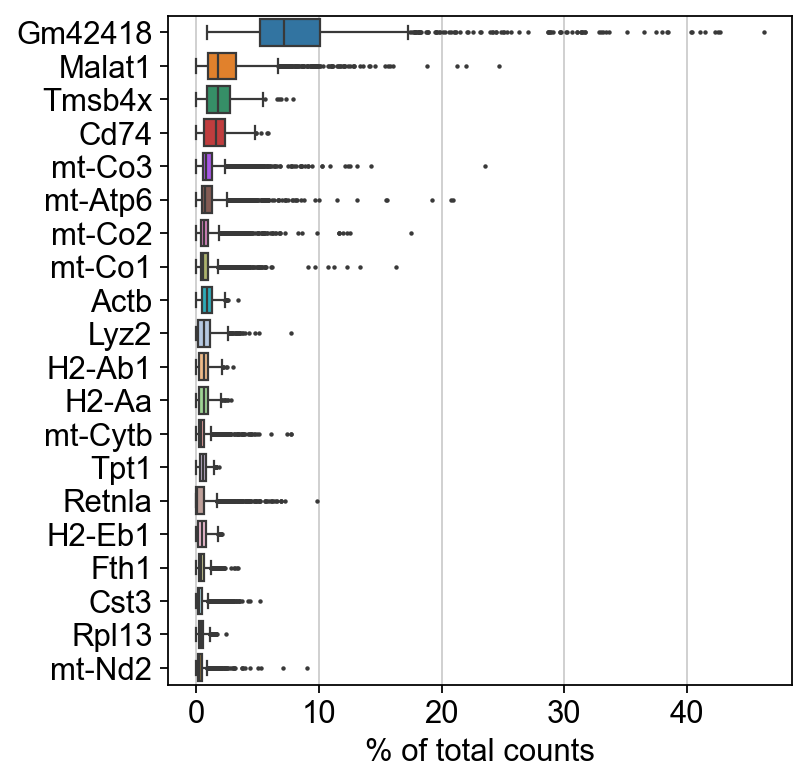

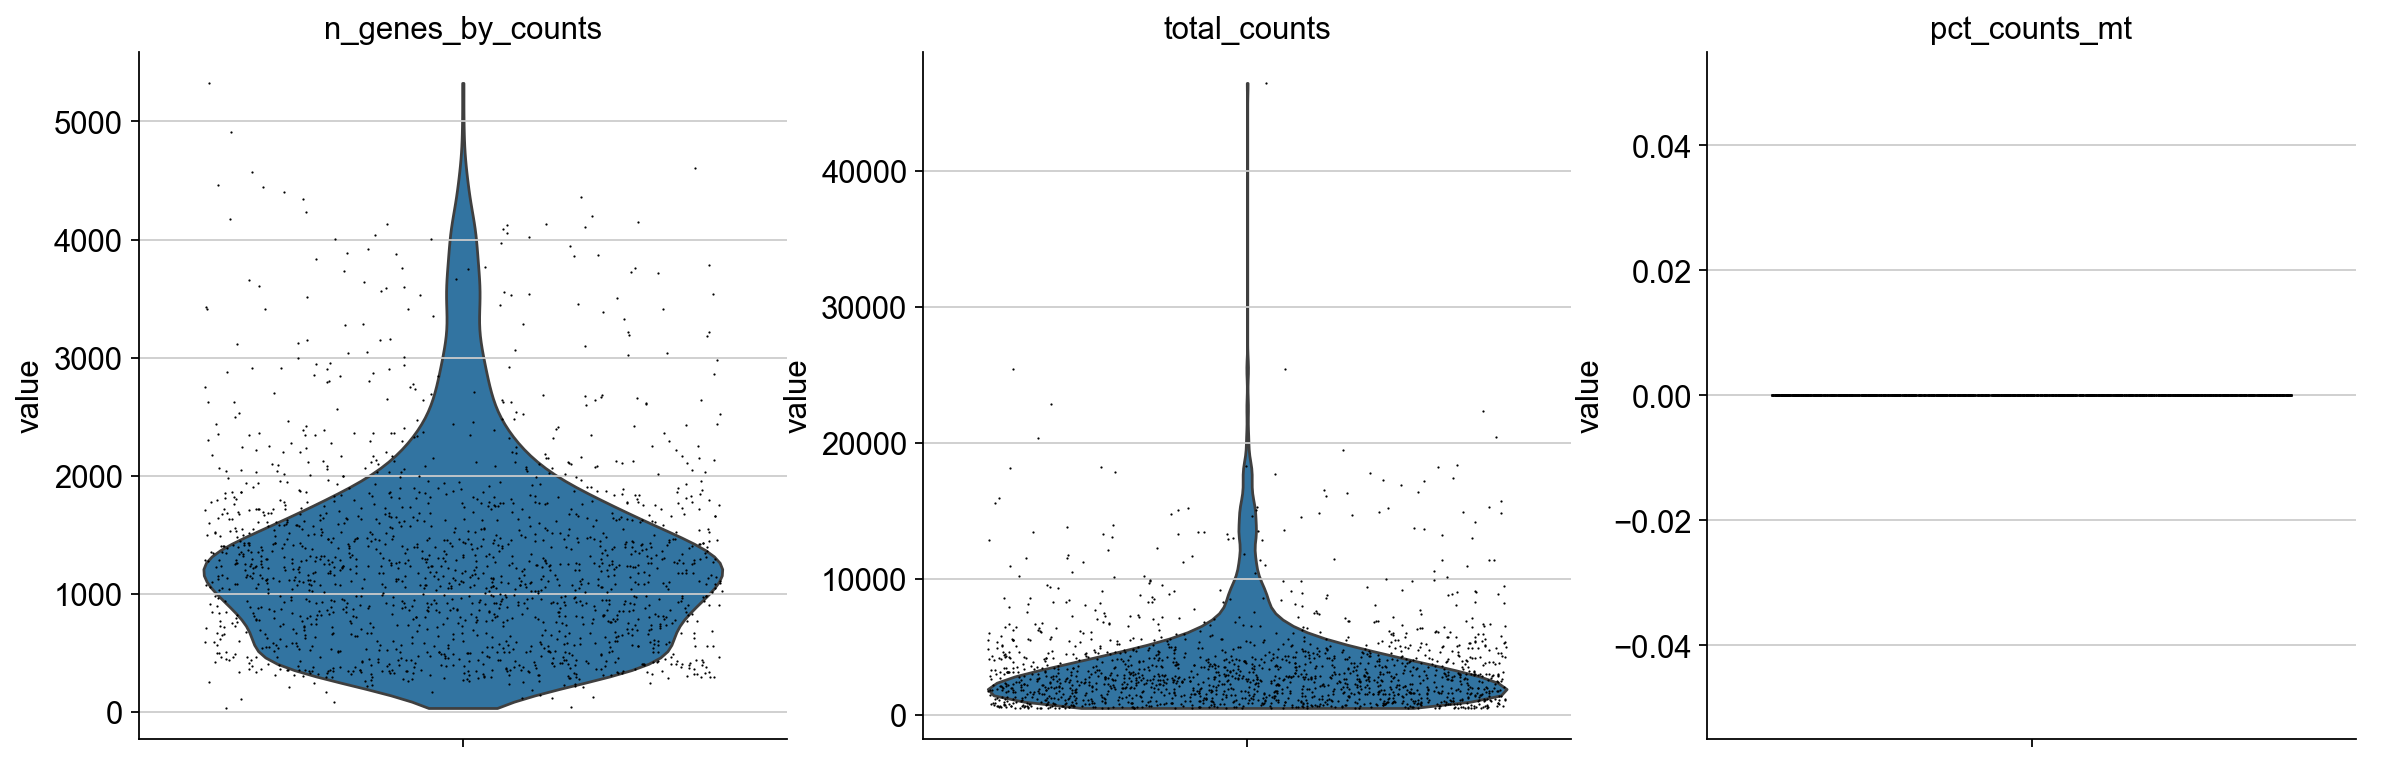

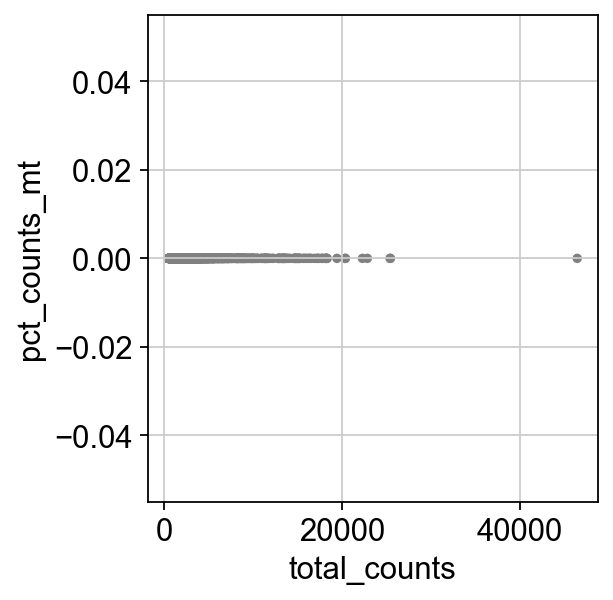

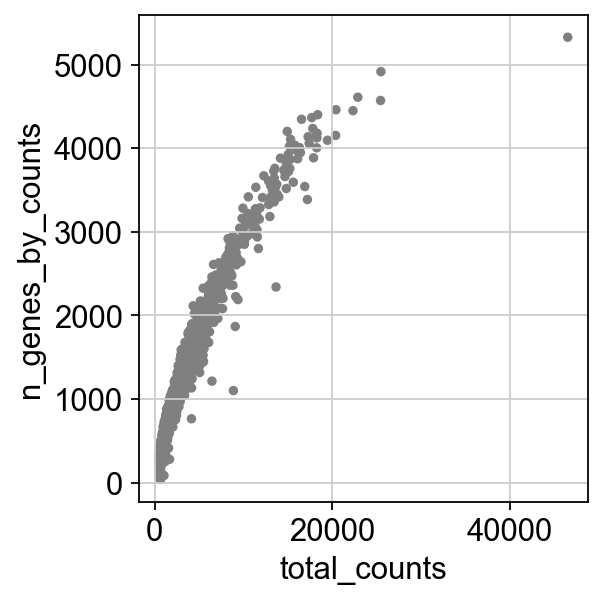

adata shape after filtering: (1652, 32285)
Number of var_names: 32285
First 10 var_names: Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1'],
      dtype='object')
filtered out 3 cells that have less than 100 genes expressed
filtered out 19261 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
1649
                    Mrpl15  Lypla1     Tcea1  Atp6v1h    Rb1cc1  \
AAACCCAAGACAGCTG-1     0.0     0.0  0.000000      0.0  0.000000   
AAACCCACAAAGACGC-1     0.0     0.0  0.000000      0.0  1.921457   
AAACGAAAGCACTCGC-1     0.0     0.0  0.000000      0.0  0.000000   
AAACGAACAAATGGTA-1     0.0     0.0  0.000000      0.0  0.000000   
AAAGGATGTGTGTTTG-1     0.0     0.0  0.000000      0.0  2.565319   
...                    ...     ...       ...      ...       ...   
TTTGGTTCAGTGGCTC-1     0.0     0.0  0.000000      0.0  0.000000   
TTTGGTTGTAACGTTC-1     0.0     0.0  0.000000      0.0  0.0

In [12]:
realmat = sc.read_mtx('matrix.mtx')
realfeature=pd.read_csv('features.tsv',sep='\t',header=None)
realmat=realmat[0:32285]
realtag=pd.read_csv('tag.csv')
actt=realfeature.loc[realfeature[2] == 'Gene Expression']
celltag=pd.read_csv('barcodes.tsv',sep='\t',header=None)
adata = anndata.AnnData(X=realmat.X.T)
lol = list(celltag[0])  # or pd.Series(actt[1])
adata.obs['cell'] = lol

lmao = list(actt[1])  # or pd.Series(actt[1])
adata.var['gene_ids'] = lmao
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
# sc.pp.filter_cells(adata, min_genes=100)
# sc.pp.filter_genes(adata, min_cells=3)
adata

adata.var['mt'] =  adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'






sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var
# Remove headers and set the index to 'gene_ids'
adata.var.index = adata.var['gene_ids'].values
adata.var.index.name = None  # This removes the header (name) of the index
adata.obs
sc.pl.highest_expr_genes(adata, n_top=20, )
adata.var_names_make_unique()  # this is unnecessary if us
#adata.var.index = actt[1].astype('string')
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')




 
print("adata shape after filtering:", adata.shape)
print("Number of var_names:", len(adata.var_names))
print("First 10 var_names:", adata.var_names[:10])

# (B) Filter out cells with fewer than e.g. 200 genes
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)



sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
METT=adata.X
dense_matrix = METT.toarray()

#METT = METT[~METT['cell'].isin(realtag['cell_barcode'])
# Convert the dense NumPy array to a Pandas DataFrame
METT = pd.DataFrame(dense_matrix,columns=adata.var_names, index=adata.obs['cell'].values)
METT['cell']=adata.obs['cell'].values
realtag.index=realtag['cell_barcode'].values
result = METT.join(realtag[['feature_call']], how='left')
print(METT.index.isin(realtag.index).sum())
result
# Remove rows where 'gender' is NaN
result = result.dropna(subset=['feature_call'])

print(result)
# Initialize the 'gender' column with NaN or some default value
result['gender'] = None

# Update 'gender' based on 'feature_call'
result.loc[result['feature_call'] == 'CMO305', 'gender'] = 1
result.loc[result['feature_call'] == 'CMO306', 'gender'] = 0
print(result)

In [14]:
X_test_result = result.drop(columns=['cell', 'feature_call', 'gender'])  # Drop non-feature columns in result
y_test_result = result['gender']  # Target variable
y_test_result = y_test_result.astype(int)


# GSE129798: Kidney


https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE129798
kidney

In [31]:

# Now split into X and Y
Y = rc_shuffled["y"]
X = rc_shuffled.drop("y", axis=1)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (6648, 17153)
Shape of Y: (6648,)


In [ ]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np

# ------------------------------------------------------------------------------
# 1) File paths
# ------------------------------------------------------------------------------
mtx_file = "/Users/haley/Desktop/send_tooo/GSE129798/matrix.mtx"
genes_file = "/Users/haley/Desktop/send_tooo/GSE129798/genes.tsv"
barcodes_file = "/Users/haley/Desktop/send_tooo/GSE129798/barcodes.tsv"

# ------------------------------------------------------------------------------
# 2) Read the raw matrix (n_genes x n_barcodes)
# ------------------------------------------------------------------------------
raw_mtx = sc.read_mtx(mtx_file)  # shape: (n_genes, n_barcodes)

# ------------------------------------------------------------------------------
# 3) Read genes.tsv and barcodes.tsv
# ------------------------------------------------------------------------------
genes_df = pd.read_csv(genes_file, header=None, sep="\t")
barcodes_df = pd.read_csv(barcodes_file, header=None, sep="\t")

# ------------------------------------------------------------------------------
# 4) Create an AnnData object, transpose => (cells x genes)
# ------------------------------------------------------------------------------
adata = anndata.AnnData(X=raw_mtx.X.transpose())

# ------------------------------------------------------------------------------
# 5) Assign gene info to adata.var
# ------------------------------------------------------------------------------
if genes_df.shape[1] == 1:
    # Only 1 column => treat as both gene_id & gene_symbol
    adata.var["gene_id"] = genes_df[0].values
    adata.var["gene_symbol"] = genes_df[0].values
elif genes_df.shape[1] == 2:
    # 2 columns => (gene_id, gene_symbol)
    adata.var["gene_id"] = genes_df[0].values
    adata.var["gene_symbol"] = genes_df[1].values
else:
    raise ValueError("Unexpected number of columns in genes.tsv")

adata.var_names = adata.var["gene_symbol"].astype(str)

# ------------------------------------------------------------------------------
# 6) Assign barcodes to .obs, parse region, sex, replicate
# ------------------------------------------------------------------------------
adata.obs["full_barcode"] = barcodes_df[0].values
adata.obs_names = adata.obs["full_barcode"].astype(str)

def parse_custom_barcode(full_bc):
    """
    Example: "Z1_F_F2_AGTTGGTCAGTTCCCT"
       -> region="Z1", sex="F", replicate="F2", raw_bc="AGTTGGTCAGTTCCCT"
    If format differs, fallback = ("NA","NA","NA", full_bc).
    """
    parts = full_bc.split("_")
    if len(parts) == 4:
        region, sex, replicate, raw_bc = parts
    else:
        region, sex, replicate, raw_bc = ("NA", "NA", "NA", full_bc)
    return region, sex, replicate, raw_bc

adata.obs["region"] = None
adata.obs["sex"] = None
adata.obs["replicate"] = None
adata.obs["raw_bc"] = None

for cell_name in adata.obs_names:
    region, sex, replicate, raw_bc = parse_custom_barcode(cell_name)
    adata.obs.at[cell_name, "region"]    = region
    adata.obs.at[cell_name, "sex"]       = sex
    adata.obs.at[cell_name, "replicate"] = replicate
    adata.obs.at[cell_name, "raw_bc"]    = raw_bc

# Optionally set obs_names to raw_bc
adata.obs_names = adata.obs["raw_bc"]
del adata.obs["raw_bc"]

# ------------------------------------------------------------------------------
# 7) Make observation names unique (fix the warning).
# ------------------------------------------------------------------------------
adata.obs_names_make_unique()

# ------------------------------------------------------------------------------
# 8) "batch" = region (only if region is truly technical, else skip ComBat!)
# ------------------------------------------------------------------------------
adata.obs["batch"] = adata.obs["region"].astype(str)
print("Unique regions:", adata.obs["region"].unique())
print("Distinct 'batch' labels:", adata.obs["batch"].unique())

# ------------------------------------------------------------------------------
# 9) Filter genes: keep only genes in >= 3 cells
# ------------------------------------------------------------------------------
sc.pp.filter_genes(adata, min_cells=3)
print("adata shape after filtering:", adata.shape)
print("Number of var_names:", len(adata.var_names))
print("First 10 var_names:", adata.var_names[:10])

# (B) Filter out cells with fewer than e.g. 200 genes
sc.pp.filter_cells(adata, min_genes=200)

# Identify mitochondrial genes: (Adjust prefix if needed, e.g. "mt-" for mouse)
adata.var["mt"] = adata.var_names.str.startswith("mt-")

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

# (C) Filter out cells with high mitochondrial content, e.g. > 5%
max_mito_percent = 5
adata_all = adata[adata.obs["pct_counts_mt"] < max_mito_percent, :].copy()





# ------------------------------------------------------------------------------
# 10) Normalize & log transform
# ------------------------------------------------------------------------------
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

print("\n=== Post-QC AnnData ===")
print(adata)
print("Example rows in adata.obs:\n", adata.obs.head())

# ------------------------------------------------------------------------------
# 11) Verify shape right before DataFrame
# ------------------------------------------------------------------------------
print("\nShape just before building DataFrame:", adata.shape)
print("adata.X type:", type(adata.X))
print("adata.var_names length:", len(adata.var_names))
print("adata.obs_names length:", len(adata.obs_names))

# ------------------------------------------------------------------------------
# 12) Build the uncorrected DataFrame
# ------------------------------------------------------------------------------
X_extra_1_df = pd.DataFrame(
    data=adata.X if isinstance(adata.X, np.ndarray) else adata.X.toarray(),
    index=adata.obs_names,
    columns=adata.var_names
)

# Convert 'sex' => numeric label  M=1, F=0, fill missing=-1
sex_series = adata.obs["sex"].astype(str)
y_extra_1 = sex_series.map({"M": 1, "F": 0}).fillna(-1).values


 
# ------------------------------------------------------------------------------
# 15) Done. (Check for single-sex regions or real biology vs. batch)
# ------------------------------------------------------------------------------
 
print("  X_extra_1_df       (uncorrected)")
 
 


Unique regions: ['Z1' 'Z2' 'Z3']
Distinct 'batch' labels: ['Z1' 'Z2' 'Z3']
filtered out 53 genes that are detected in less than 3 cells
adata shape after filtering: (31265, 19072)
Number of var_names: 19072
First 10 var_names: Index(['Xkr4', 'Gm37381', 'Rp1', 'Sox17', 'Gm37323', 'Mrpl15', 'Lypla1',
       'Gm37988', 'Tcea1', 'Atp6v1h'],
      dtype='object', name='gene_symbol')
normalizing counts per cell
    finished (0:00:00)

=== Post-QC AnnData ===
AnnData object with n_obs × n_vars = 31265 × 19072
    obs: 'full_barcode', 'region', 'sex', 'replicate', 'batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'gene_symbol', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [ ]:
#!/usr/bin/env python3
"""
Pre-processing for GSE129798 → AnnData + CSV exports
 
"""

import os
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import scipy.sparse as sp        # for issparse check

# ─────────────────────────────────────────────────────────────
# 1) File paths
# ─────────────────────────────────────────────────────────────
base_dir = "/Users/haley/Desktop/send_tooo/GSE129798"
mtx_file   = f"{base_dir}/matrix.mtx"
genes_file = f"{base_dir}/genes.tsv"
bcs_file   = f"{base_dir}/barcodes.tsv"

# Output directory
out_dir = "/Users/haley/Desktop/send_tooo/data"
os.makedirs(out_dir, exist_ok=True)

# ─────────────────────────────────────────────────────────────
# 2) Read raw matrix (genes × barcodes) and metadata
# ─────────────────────────────────────────────────────────────
raw_mtx  = sc.read_mtx(mtx_file)               # sparse CSC/CSR
genes_df = pd.read_csv(genes_file, header=None, sep="\t")
bcs_df   = pd.read_csv(bcs_file,   header=None, sep="\t")

# ─────────────────────────────────────────────────────────────
# 3) Build AnnData (cells × genes)
# ─────────────────────────────────────────────────────────────
adata = anndata.AnnData(X=raw_mtx.X.transpose())

# ───── gene metadata
if genes_df.shape[1] == 1:               # one column → id = symbol
    adata.var["gene_id"]     = genes_df[0].values
    adata.var["gene_symbol"] = genes_df[0].values
elif genes_df.shape[1] == 2:             # two columns → id, symbol
    adata.var["gene_id"]     = genes_df[0].values
    adata.var["gene_symbol"] = genes_df[1].values
else:
    raise ValueError("genes.tsv has more than two columns.")
adata.var_names = adata.var["gene_symbol"].astype(str)

# ───── barcode metadata
adata.obs["full_barcode"] = bcs_df[0].values
adata.obs_names           = adata.obs["full_barcode"].astype(str)

def parse_custom_barcode(bc: str):
    """Split 'Z1_F_F2_AGTT…' → region, sex, replicate, raw_bc."""
    parts = bc.split("_")
    return parts if len(parts) == 4 else ("NA", "NA", "NA", bc)

adata.obs[["region", "sex", "replicate", "raw_bc"]] = [
    parse_custom_barcode(bc) for bc in adata.obs_names
]
adata.obs_names = adata.obs.pop("raw_bc").astype(str)
adata.obs_names_make_unique()

# ─────────────────────────────────────────────────────────────
# 4) Basic QC filters
# ─────────────────────────────────────────────────────────────
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)

adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

adata_qc = adata[adata.obs["pct_counts_mt"] < 5].copy()
print(f"[QC] kept {adata_qc.n_obs} cells and {adata_qc.n_vars} genes")

# ─────────────────────────────────────────────────────────────
# 5) Normalise + log-transform
# ─────────────────────────────────────────────────────────────
sc.pp.normalize_total(adata_qc, target_sum=1e4)
sc.pp.log1p(adata_qc)

# ─────────────────────────────────────────────────────────────
# 6) Convert to DataFrame + label vector
# ─────────────────────────────────────────────────────────────
if sp.issparse(adata_qc.X):
    X_mat = adata_qc.X.toarray()   # beware RAM if huge
else:
    X_mat = adata_qc.X

X_extra_1_df = pd.DataFrame(
    data=X_mat,
    index=adata_qc.obs_names,
    columns=adata_qc.var_names
)

y_extra_1 = (
    adata_qc.obs["sex"]
    .astype(str)
    .map({"M": 1, "F": 0})
    .fillna(-1)
)

 


In [138]:
#!/usr/bin/env python3
# Train and test classification models with AUROC/AUPRC export

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    roc_curve, precision_recall_curve,
    roc_auc_score, average_precision_score
)
from pathlib import Path

# List of marker genes
subset_genes = [
    "Xist", "Ddx3y", "Gm42418", "Eif2s3y", "Rps27rt",
    "Rpl9-ps6", "Kdm5d", "Uba52", "Rpl35", "Rpl36a-ps1",
    "Uty", "Wdr89", "Lars2", "Rps27"
]

# Output directory
out_dir = Path("/Users/haley/Desktop/send_tooo/AAA_final")
out_dir.mkdir(parents=True, exist_ok=True)

######################################
# 0) Align indices & coerce label types
######################################
# If X is a DataFrame but Y is an array, wrap Y as a Series
if isinstance(X, pd.DataFrame) and not isinstance(Y, pd.Series):
    Y = pd.Series(Y, index=X.index)

# If X_extra_1_df is DataFrame but y_extra_1 is array, wrap it as a Series
if isinstance(X_extra_1_df, pd.DataFrame) and not isinstance(y_extra_1, pd.Series):
    y_extra_1 = pd.Series(y_extra_1, index=X_extra_1_df.index)

# Now align indices if both are DataFrame & Series
if isinstance(X, pd.DataFrame) and isinstance(Y, pd.Series):
    if not X.index.equals(Y.index):
        common = X.index.intersection(Y.index)
        X = X.loc[common]
        Y = Y.loc[common]

if isinstance(X_extra_1_df, pd.DataFrame) and isinstance(y_extra_1, pd.Series):
    if not X_extra_1_df.index.equals(y_extra_1.index):
        common = X_extra_1_df.index.intersection(y_extra_1.index)
        X_extra_1_df = X_extra_1_df.loc[common]
        y_extra_1 = y_extra_1.loc[common]

######################################
# 1) Find common genes and subset to marker genes
######################################
if not (isinstance(X, pd.DataFrame) and isinstance(X_extra_1_df, pd.DataFrame)):
    raise ValueError("X and X_extra_1_df must be DataFrames with gene columns")

common_genes = sorted(set(X.columns).intersection(X_extra_1_df.columns))
print(f"Found {len(common_genes)} shared genes")

# Subset to marker genes
final_genes = sorted(set(subset_genes).intersection(common_genes))
if not final_genes:
    raise ValueError("None of the marker genes found in your data")

print(f"Subsetting to {len(final_genes)} marker genes:", final_genes)

# Subset data to marker genes
X_train = X[final_genes]
X_test = X_extra_1_df[final_genes]

######################################
# 2) Prepare arrays and scale
######################################
# Train labels array
Y_train_arr = Y.values if isinstance(Y, pd.Series) else Y

# Test labels array
Y_test_arr = y_extra_1.values if isinstance(y_extra_1, pd.Series) else y_extra_1

# Ensure labels are properly formatted as integer arrays
Y_train_arr = np.array(Y_train_arr).astype(int)
Y_test_arr = np.array(Y_test_arr).astype(int)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

######################################
# 3) Train models and collect curves
######################################
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "LinearSVC": SVC(kernel='linear', probability=True, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42,
                  n_estimators=100, learning_rate=0.05, max_depth=10),
    "RandomForest": RandomForestClassifier(max_depth=10, random_state=42)
}

results = []
curve_data_roc = []
curve_data_pr = []

# Set up colors for plotting
colors = {
    "LogisticRegression": "blue",
    "LinearSVC": "red",
    "XGBoost": "green",
    "RandomForest": "purple"
}

# Create figures for plotting
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))
fig_pr, ax_pr = plt.subplots(figsize=(10, 8))

for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train_scaled, Y_train_arr)

    # Train metrics
    p_tr = model.predict(X_train_scaled)
    prob_tr = model.predict_proba(X_train_scaled)[:, 1]
    tr_acc = accuracy_score(Y_train_arr, p_tr)
    tr_f1 = f1_score(Y_train_arr, p_tr)
    tr_roc = roc_auc_score(Y_train_arr, prob_tr)
    tr_pr = average_precision_score(Y_train_arr, prob_tr)
    print(f" TRAIN → Acc={tr_acc:.4f}, F1={tr_f1:.4f}, AUROC={tr_roc:.4f}, AUPRC={tr_pr:.4f}")

    # Test metrics
    p_test = model.predict(X_test_scaled)
    prob_test = model.predict_proba(X_test_scaled)[:, 1]
    test_acc = accuracy_score(Y_test_arr, p_test)
    test_f1 = f1_score(Y_test_arr, p_test)
    test_roc = roc_auc_score(Y_test_arr, prob_test)
    test_pr = average_precision_score(Y_test_arr, prob_test)
    print(f" TEST → Acc={test_acc:.4f}, F1={test_f1:.4f}, AUROC={test_roc:.4f}, AUPRC={test_pr:.4f}")
    print("  Confusion Matrix:")
    print(confusion_matrix(Y_test_arr, p_test))

    results.append({
        "Model": name,
        "Train_Acc": tr_acc, "Train_F1": tr_f1,
        "Train_AUROC": tr_roc, "Train_AUPRC": tr_pr,
        "Test_Acc": test_acc, "Test_F1": test_f1,
        "Test_AUROC": test_roc, "Test_AUPRC": test_pr,
    })
    
    # Calculate ROC curve points
    fpr, tpr, _ = roc_curve(Y_test_arr, prob_test)
    roc_df = pd.DataFrame({"model": name, "fpr": fpr, "tpr": tpr})
    curve_data_roc.append(roc_df)
    
    # Calculate PR curve points
    precision, recall, _ = precision_recall_curve(Y_test_arr, prob_test)
    pr_df = pd.DataFrame({"model": name, "precision": precision, "recall": recall})
    curve_data_pr.append(pr_df)
    
    # Plot ROC curve
    ax_roc.plot(fpr, tpr, lw=2, color=colors[name], 
             label=f'{name} (area = {test_roc:.3f})')
    
    # Plot PR curve
    ax_pr.plot(recall, precision, lw=2, color=colors[name], 
            label=f'{name} (area = {test_pr:.3f})')

# Combine and save curve data
all_roc_data = pd.concat(curve_data_roc, ignore_index=True)
all_pr_data = pd.concat(curve_data_pr, ignore_index=True)

all_roc_data.to_csv(out_dir / "test_1_auroc.csv", index=False)
all_pr_data.to_csv(out_dir / "test_1_auprc.csv", index=False)

# Finalize and save ROC plot
ax_roc.plot([0, 1], [0, 1], 'k--', lw=2)
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('Receiver Operating Characteristic (ROC) Curves')
ax_roc.legend(loc="lower right")
ax_roc.grid(True, linestyle='--', alpha=0.7)
fig_roc.tight_layout()
fig_roc.savefig(out_dir / "test_1_all_roc_curves.png", dpi=300, bbox_inches='tight')

# Finalize and save PR plot
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_ylim([0.0, 1.05])
ax_pr.set_xlim([0.0, 1.0])
ax_pr.set_title('Precision-Recall Curves')
ax_pr.legend(loc="lower left")
ax_pr.grid(True, linestyle='--', alpha=0.7)
fig_pr.tight_layout()
fig_pr.savefig(out_dir / "test_1_all_pr_curves.png", dpi=300, bbox_inches='tight')

plt.close('all')

# Save summary results
results_df = pd.DataFrame(results)
print("\nFinal results:")
print(results_df)

results_df.to_csv(out_dir / "test_1_summary_results.csv", index=False)
print(f"All results saved to {out_dir}")

Found 14673 shared genes
Subsetting to 13 marker genes: ['Ddx3y', 'Eif2s3y', 'Gm42418', 'Kdm5d', 'Lars2', 'Rpl35', 'Rpl9-ps6', 'Rps27', 'Rps27rt', 'Uba52', 'Uty', 'Wdr89', 'Xist']

=== LogisticRegression ===
 TRAIN → Acc=0.8997, F1=0.8809, AUROC=0.9672, AUPRC=0.9483
 TEST → Acc=0.7475, F1=0.7095, AUROC=0.9666, AUPRC=0.9675
  Confusion Matrix:
[[13731   376]
 [ 7517  9641]]

=== LinearSVC ===
 TRAIN → Acc=0.9024, F1=0.8843, AUROC=0.9663, AUPRC=0.9448
 TEST → Acc=0.7326, F1=0.6853, AUROC=0.9660, AUPRC=0.9667
  Confusion Matrix:
[[13799   308]
 [ 8053  9105]]

=== XGBoost ===
 TRAIN → Acc=0.9437, F1=0.9328, AUROC=0.9893, AUPRC=0.9840
 TEST → Acc=0.7410, F1=0.7007, AUROC=0.9615, AUPRC=0.9628
  Confusion Matrix:
[[13684   423]
 [ 7676  9482]]

=== RandomForest ===
 TRAIN → Acc=0.9301, F1=0.9181, AUROC=0.9847, AUPRC=0.9769
 TEST → Acc=0.7628, F1=0.7367, AUROC=0.9618, AUPRC=0.9627
  Confusion Matrix:
[[13474   633]
 [ 6782 10376]]

Final results:
                Model  Train_Acc  Train_F1  Tr

In [23]:
#!/usr/bin/env python

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    roc_curve, precision_recall_curve,
    roc_auc_score, average_precision_score
)

##############################################################################
# (A) ALIAS DICTIONARY & LABEL-UNIFY HELPERS
##############################################################################
alias_to_official = {
    "XIST":"Xist","RPS27RT":"Rps27rt","DDX3Y":"Ddx3y","RPL35":"Rpl35",
    "EIF2S3Y":"Eif2s3y","EIF2S3L":"Eif2s3y","GM42418":"Gm42418","UBA52":"Uba52",
    "RPL36A-PS1":"Rpl36a-ps1","KDM5D":"Kdm5d","JARID1D":"Kdm5d","WDR89":"Wdr89",
    "UTY":"Uty","LARS2":"Lars2","AY036118":"AY036118","RPL9-PS6":"Rpl9-ps6",
    "TSIX":"Tsix", "SOD1":"Sod1", "RPS25":"Rps25", 
    "ARGLU1":"Arglu1", "SDC4":"Sdc4", "RPS29":"Rps29"
}

def unify_gene_symbols(df):
    if not isinstance(df, pd.DataFrame):
        return df
    df = df.copy()
    df.columns = [alias_to_official.get(c.upper(), c) for c in df.columns]
    # If duplicates remain after that, group by column name and average
    if df.columns.duplicated().any():
        df = df.groupby(df.columns, axis=1).mean()
    return df

def unify_labels(labels):
    mapping = {'F':0,'M':1,'female':0,'male':1,'0':0,'1':1,'0.0':0,'1.0':1,'f':0,'m':1}
    s = pd.Series(labels).astype(str).str.strip().str.lower()
    m = s.map(mapping)
    if m.isna().any():
        bad = s[m.isna()].unique()
        raise ValueError(f"Unrecognized labels: {bad}")
    return m.astype(int)

##############################################################################
# (B) NEW SEX-MARKER GENE LIST
##############################################################################
marker_genes = ['Xist', 'Lars2', 'Tsix', 'Sod1', 'Ddx3y', 'Eif2s3y', 
                'Rps25', 'Arglu1', 'Sdc4', 'Kdm5d', 'Rps29']

# Output directory for results
out_dir = Path("/Users/haley/Desktop/send_tooo/AAA_final/colon_to_data6_results")
out_dir.mkdir(parents=True, exist_ok=True)

##############################################################################
# (C) LOAD TRAINING DATA (COLON) AND TEST DATA (DATA6)
##############################################################################

# Load colon training data
print("[INFO] Loading colon training data...")
X_train_raw = pd.read_csv("X_extra_5_filtered.csv", index_col=0)
df_train_labels = pd.read_csv("Y_extra_5_filtered.csv", index_col=0, header=0)
Y_train_raw = df_train_labels["sex_label"]   # or whichever column name holds your labels

print(f"[INFO] Colon train X shape: {X_train_raw.shape}")
print(f"[INFO] Colon train Y length: {len(Y_train_raw)}")

# Load data1 test data (assuming variables are already in memory from data1 processing)
print("[INFO] Loading data1 test data...")
X_test_raw = X_extra_1_df  # From data1 processing script
Y_test_raw = y_extra_1     # From data1 processing script

print(f"[INFO] Data1 test X shape: {X_test_raw.shape}")
print(f"[INFO] Data1 test Y length: {len(Y_test_raw)}")

##############################################################################
# (D) PREPROCESS INPUTS
##############################################################################
X_train_clean = unify_gene_symbols(X_train_raw)
X_test_clean = unify_gene_symbols(X_test_raw)

Y_train = unify_labels(Y_train_raw)
# For data1, y_extra_1 uses -1 for unknown sex, so we need to handle this
Y_test_numeric = pd.Series(Y_test_raw, index=X_test_clean.index)
# Filter out unknown sex samples (-1 values)
valid_test_mask = Y_test_numeric != -1
Y_test = Y_test_numeric[valid_test_mask]
X_test_clean = X_test_clean[valid_test_mask]

print(f"[INFO] Filtered out {(~valid_test_mask).sum()} samples with unknown sex from test data")

# Ensure labels are aligned with rows
Y_train = pd.Series(Y_train, index=X_train_clean.index)
Y_test = pd.Series(Y_test, index=X_test_clean.index)

# Keep only samples present in both data & labels
idx_tr = X_train_clean.index.intersection(Y_train.index)
idx_te = X_test_clean.index.intersection(Y_test.index)

X_train_clean = X_train_clean.loc[idx_tr].copy()
Y_train = Y_train.loc[idx_tr].copy()
X_test_clean = X_test_clean.loc[idx_te].copy()
Y_test = Y_test.loc[idx_te].copy()

# Drop duplicate row indices (keep first occurrence)
for obj in [X_train_clean, Y_train, X_test_clean, Y_test]:
    if hasattr(obj, 'index'):
        dup = obj.index.duplicated(keep="first")
        if dup.any():
            if isinstance(obj, pd.DataFrame):
                obj.drop(index=obj.index[dup], inplace=True)
            else:  # Series
                obj.drop(obj.index[dup], inplace=True)

print(f"[INFO] After preprocessing - Train shape: {X_train_clean.shape} | Test shape: {X_test_clean.shape}")

# Additional check: ensure no NaN values in labels
train_nan_count = Y_train.isna().sum()
test_nan_count = Y_test.isna().sum()
if train_nan_count > 0:
    print(f"[WARNING] Found {train_nan_count} NaN values in training labels")
    Y_train = Y_train.dropna()
    X_train_clean = X_train_clean.loc[Y_train.index]
if test_nan_count > 0:
    print(f"[WARNING] Found {test_nan_count} NaN values in test labels")
    Y_test = Y_test.dropna()
    X_test_clean = X_test_clean.loc[Y_test.index]

print(f"[INFO] Final shapes after NaN removal - Train: {X_train_clean.shape} | Test: {X_test_clean.shape}")

##############################################################################
# (E) Find common genes between train and test
##############################################################################
common_genes = sorted(set(X_train_clean.columns) & set(X_test_clean.columns))
if not common_genes:
    raise ValueError("No common genes between train and test datasets")
print(f"[INFO] Found {len(common_genes)} shared genes")

##############################################################################
# (F) Subset to marker genes
##############################################################################
final_genes = sorted(set(marker_genes) & set(common_genes))
missing_genes = set(marker_genes) - set(common_genes)

if len(final_genes) != len(marker_genes):
    print(f"[WARNING] Found {len(final_genes)}/{len(marker_genes)} marker genes")
    if missing_genes:
        print(f"[WARNING] Missing genes: {missing_genes}")

print(f"[INFO] Using {len(final_genes)} marker genes: {final_genes}")

# Subset data to marker genes only
X_train = X_train_clean[final_genes]
X_test = X_test_clean[final_genes]

Y_train_arr = Y_train.values
Y_test_arr = Y_test.values

# Print class distribution
print(f"[INFO] Training data class distribution:")
print(f"  Female (0): {np.sum(Y_train_arr == 0)} samples")
print(f"  Male (1): {np.sum(Y_train_arr == 1)} samples")
print(f"[INFO] Test data class distribution:")
print(f"  Female (0): {np.sum(Y_test_arr == 0)} samples")
print(f"  Male (1): {np.sum(Y_test_arr == 1)} samples")
print(f"  Unknown (-1): 0 samples (filtered out)")

# Verify no invalid values remain
print(f"[INFO] Unique values in Y_train_arr: {np.unique(Y_train_arr)}")
print(f"[INFO] Unique values in Y_test_arr: {np.unique(Y_test_arr)}")
print(f"[INFO] Any NaN in Y_train_arr: {np.isnan(Y_train_arr).any()}")
print(f"[INFO] Any NaN in Y_test_arr: {np.isnan(Y_test_arr).any()}")

##############################################################################
# (G) Feature scaling
##############################################################################
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

##############################################################################
# (H) Model training & evaluation
##############################################################################
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "LinearSVC": SVC(kernel='linear', probability=True, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42,
                  n_estimators=100, learning_rate=0.05, max_depth=10),
    "RandomForest": RandomForestClassifier(max_depth=10, random_state=42)
}

# Set up for curve data collection and plotting
curve_data_roc = []
curve_data_pr = []
colors = {
    "LogisticRegression": "blue",
    "LinearSVC": "red", 
    "XGBoost": "green",
    "RandomForest": "purple"
}

# Create figures for plotting
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))
fig_pr, ax_pr = plt.subplots(figsize=(10, 8))

results = []
feature_importance_data = []

for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train_scaled, Y_train_arr)

    # 1) Train performance
    p_tr = model.predict(X_train_scaled)
    prob_tr = model.predict_proba(X_train_scaled)[:, 1]
    tr_acc = accuracy_score(Y_train_arr, p_tr)
    tr_f1 = f1_score(Y_train_arr, p_tr)
    tr_roc = roc_auc_score(Y_train_arr, prob_tr)
    tr_pr = average_precision_score(Y_train_arr, prob_tr)
    print(f" TRAIN → Acc={tr_acc:.4f}, F1={tr_f1:.4f}, AUROC={tr_roc:.4f}, AUPRC={tr_pr:.4f}")

    # 2) Test performance
    p_test = model.predict(X_test_scaled)
    prob_test = model.predict_proba(X_test_scaled)[:, 1]
    test_acc = accuracy_score(Y_test_arr, p_test)
    test_f1 = f1_score(Y_test_arr, p_test)
    test_roc = roc_auc_score(Y_test_arr, prob_test)
    test_pr = average_precision_score(Y_test_arr, prob_test)
    print(f" TEST → Acc={test_acc:.4f}, F1={test_f1:.4f}, AUROC={test_roc:.4f}, AUPRC={test_pr:.4f}")
    
    cm = confusion_matrix(Y_test_arr, p_test)
    print("  Confusion Matrix:")
    print(f"    [[{cm[0,0]:3d} {cm[0,1]:3d}]")
    print(f"     [{cm[1,0]:3d} {cm[1,1]:3d}]]")
    
    results.append({
        "Model": name,
        "Train_Acc": tr_acc, "Train_F1": tr_f1,
        "Train_AUROC": tr_roc, "Train_AUPRC": tr_pr,
        "Test_Acc": test_acc, "Test_F1": test_f1,
        "Test_AUROC": test_roc, "Test_AUPRC": test_pr,
    })
    
    # Extract feature importance
    if hasattr(model, "coef_"):
        # Linear model: use absolute value of coefficients
        importances = np.abs(model.coef_[0])
    elif hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    else:
        importances = np.zeros(len(final_genes))
    
    for gene, importance in zip(final_genes, importances):
        feature_importance_data.append({
            "Model": name,
            "Gene": gene,
            "Importance": importance
        })
    
    # Calculate ROC curve points
    fpr, tpr, _ = roc_curve(Y_test_arr, prob_test)
    roc_df = pd.DataFrame({"model": name, "fpr": fpr, "tpr": tpr})
    curve_data_roc.append(roc_df)
    
    # Calculate PR curve points
    precision, recall, _ = precision_recall_curve(Y_test_arr, prob_test)
    pr_df = pd.DataFrame({"model": name, "precision": precision, "recall": recall})
    curve_data_pr.append(pr_df)
    
    # Plot ROC curve
    ax_roc.plot(fpr, tpr, lw=2, color=colors[name], 
             label=f'{name} (area = {test_roc:.3f})')
    
    # Plot PR curve
    ax_pr.plot(recall, precision, lw=2, color=colors[name], 
            label=f'{name} (area = {test_pr:.3f})')

# Combine and save curve data
all_roc_data = pd.concat(curve_data_roc, ignore_index=True)
all_pr_data = pd.concat(curve_data_pr, ignore_index=True)

all_roc_data.to_csv(out_dir / "colon_to_data1_auroc.csv", index=False)
all_pr_data.to_csv(out_dir / "colon_to_data1_auprc.csv", index=False)

# Save feature importance data
feature_importance_df = pd.DataFrame(feature_importance_data)
feature_importance_df.to_csv(out_dir / "colon_to_data1_feature_importance.csv", index=False)

# Finalize and save ROC plot
ax_roc.plot([0, 1], [0, 1], 'k--', lw=2)
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('Colon→Data1: Receiver Operating Characteristic (ROC) Curves')
ax_roc.legend(loc="lower right")
ax_roc.grid(True, linestyle='--', alpha=0.7)
fig_roc.tight_layout()
fig_roc.savefig(out_dir / "colon_to_data1_roc_curves.png", dpi=300, bbox_inches='tight')

# Finalize and save PR plot
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_ylim([0.0, 1.05])
ax_pr.set_xlim([0.0, 1.0])
ax_pr.set_title('Colon→Data1: Precision-Recall Curves')
ax_pr.legend(loc="lower left")
ax_pr.grid(True, linestyle='--', alpha=0.7)
fig_pr.tight_layout()
fig_pr.savefig(out_dir / "colon_to_data1_pr_curves.png", dpi=300, bbox_inches='tight')

plt.close('all')

# Save summary results
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(results_df.round(4))

results_df.to_csv(out_dir / "colon_to_data1_summary_results.csv", index=False)

# Print top features for each model
print("\n" + "="*60)
print("TOP 3 FEATURES BY MODEL")
print("="*60)
for model_name in models.keys():
    model_features = feature_importance_df[feature_importance_df['Model'] == model_name]
    top_features = model_features.nlargest(3, 'Importance')
    print(f"\n{model_name}:")
    for _, row in top_features.iterrows():
        print(f"  {row['Gene']}: {row['Importance']:.4f}")

print(f"\n[INFO] All results saved to {out_dir}/")
print(f"[INFO] Key files:")
print(f"  - Summary results: colon_to_data1_summary_results.csv")
print(f"  - Feature importance: colon_to_data1_feature_importance.csv")
print(f"  - ROC curves: colon_to_data1_roc_curves.png")
print(f"  - PR curves: colon_to_data1_pr_curves.png")

[INFO] Loading colon training data...
[INFO] Colon train X shape: (4065, 21733)
[INFO] Colon train Y length: 4065
[INFO] Loading data1 test data...
[INFO] Data1 test X shape: (31265, 19072)
[INFO] Data1 test Y length: 31265
[INFO] Filtered out 0 samples with unknown sex from test data
[INFO] After preprocessing - Train shape: (4065, 21733) | Test shape: (31265, 19072)
[INFO] Final shapes after NaN removal - Train: (4065, 21733) | Test: (31265, 19072)
[INFO] Found 15385 shared genes
[INFO] Using 11 marker genes: ['Arglu1', 'Ddx3y', 'Eif2s3y', 'Kdm5d', 'Lars2', 'Rps25', 'Rps29', 'Sdc4', 'Sod1', 'Tsix', 'Xist']
[INFO] Training data class distribution:
  Female (0): 2040 samples
  Male (1): 2025 samples
[INFO] Test data class distribution:
  Female (0): 14107 samples
  Male (1): 17158 samples
  Unknown (-1): 0 samples (filtered out)
[INFO] Unique values in Y_train_arr: [0 1]
[INFO] Unique values in Y_test_arr: [0 1]
[INFO] Any NaN in Y_train_arr: False
[INFO] Any NaN in Y_test_arr: False



In [8]:

# Now split into X and Y
Y = rc_shuffled["y"]
X = rc_shuffled.drop("y", axis=1)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (6648, 17153)
Shape of Y: (6648,)


# GSE201032: Hypothalamic PVN

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE201032#:~:text=Summary%20Stress,specific%20effects%20of%20stress.%20This

In [ ]:
import pandas as pd

# Now split into X and Y
Y = rc_shuffled["y"]
X = rc_shuffled.drop("y", axis=1)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)
# Example: reading the provided metadata file
metadata_df = pd.read_csv(
    "GSE201032_Metadata.csv.gz",
    compression='gzip',  # tells pandas the file is gz-compressed
    header=0             # adjust if your file has a different header scheme
)
print("Metadata DataFrame shape:", metadata_df.shape)
display(metadata_df.head())

 


Shape of X: (6648, 17153)
Shape of Y: (6648,)
Metadata DataFrame shape: (35672, 12)


,Unnamed: 0,Experiment,Sex,Condition,nCount_RNA,nFeature_RNA,percent_mito,labelled_clusters,cell_types,DoubletScore,S.Score,G2M.Score
0,ars.female.control_AAACCTGAGAGTAATC,ars,female,control,2302,1149,0.042137,Astrocytes_3,Astrocytes,2.685284,0.005480,-0.001023
1,ars.female.control_AAAGATGCAGTCGTGC,ars,female,control,2049,1118,0.027818,Astrocytes_3,Astrocytes,2.744219,0.000594,-0.005449
2,ars.female.control_AAAGATGTCAGAGACG,ars,female,control,2974,1362,0.055145,Astrocytes_3,Astrocytes,2.290996,-0.002770,-0.019641
3,ars.female.control_AAATGCCCACTCAGGC,ars,female,control,2291,1023,0.045395,Astrocytes_3,Astrocytes,1.961591,0.048098,-0.050208
4,ars.female.control_AACACGTCAGGCGATA,ars,female,control,2816,1337,0.067827,Astrocytes_3,Astrocytes,2.437632,0.042474,0.105598


In [26]:
import os
import pandas as pd
import scanpy as sc

############################################
# 1) Define helper function for reading data
############################################
def read_custom_10x(folder: str, prefix: str, var_names="gene_symbols") -> sc.AnnData:
    """
    Reads 3 gzipped files in `folder` that match:
        prefix + "_matrix.mtx.gz"
        prefix + "_barcodes.tsv.gz"
        prefix + "_features.tsv.gz"

    Returns an AnnData object with:
        - .obs = cells
        - .var = genes
        - .X = (#cells, #genes) matrix

    This function:
        1) Reads the sparse matrix (transposed) so rows=cells, cols=genes
        2) Reads barcodes and assigns them to obs_names
        3) Reads features (genes) and assigns them to var_names
           If there's only 1 column in the file, we use it directly.
           If there are >=2 columns, we assume the second is the gene symbol.
    """
    mtx_path = os.path.join(folder, f"{prefix}_matrix.mtx.gz")
    barcodes_path = os.path.join(folder, f"{prefix}_barcodes.tsv.gz")
    features_path = os.path.join(folder, f"{prefix}_features.tsv.gz")
    
    # 1) Load sparse matrix (#genes, #cells), then transpose => (#cells, #genes)
    ad = sc.read_mtx(mtx_path).T
    
    # 2) Load barcodes (cells)
    barcodes = pd.read_csv(barcodes_path, sep="\t", header=None, compression="infer")
    ad.obs_names = barcodes[0].astype(str).tolist()
    
    # 3) Load features (genes)
    features = pd.read_csv(features_path, sep="\t", header=None, compression="infer")
    if features.shape[1] == 1:
        ad.var_names = features[0].astype(str).tolist()
    else:
        # Typically the second column is gene symbols
        ad.var_names = features[1].astype(str).tolist()

    ad.var_names_make_unique()
    
    return ad

############################################
# 2) Define the folder/prefix map for 4 conditions
############################################
base_path = "/Users/haley/Desktop/send_tooo/GSE201032_RAW"

sample_folders = {
    "baseline_ctrl": [
        (f"{base_path}/F_baseline_ctrl", "F_baseline_ctrl", "F"),
        (f"{base_path}/M_baseline_ctrl", "M_baseline_ctrl", "M"),
    ],
    "baseline_ars": [
        (f"{base_path}/F_baseline_ARS", "F_baseline_ARS", "F"),
        (f"{base_path}/M_baseline_ARS", "M_baseline_ARS", "M"),
    ],
    "cms_ctrl": [
        (f"{base_path}/F_CMS_ctrl", "F_CMS_ctrl", "F"),
        (f"{base_path}/M_CMS_ctrl", "M_CMS_ctrl", "M"),
    ],
    "cms_ars": [
        (f"{base_path}/F_CMS_ARS", "F_CMS_ARS", "F"),
        (f"{base_path}/M_CMS_ARS", "M_CMS_ARS", "M"),
    ]
}

############################################
# 3) Read, QC, and combine samples
############################################
adata_dict = {}
for cond, sample_info in sample_folders.items():
    adatas_current = []
    
    for (folder_path, prefix, sex) in sample_info:
        # Read this sample
        ad = read_custom_10x(folder=folder_path, prefix=prefix, var_names="gene_symbols")
        
        # Annotate
        ad.obs['sex'] = sex
        ad.obs['condition'] = cond
        
        # Basic QC
        sc.pp.filter_cells(ad, min_genes=200)   # remove cells w/ fewer than 200 genes
        sc.pp.filter_genes(ad, min_cells=3)     # remove genes found in fewer than 3 cells
        ad.var['mt'] = ad.var_names.str.startswith('mt-')  # identify mitochondrial genes
        sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], inplace=True)
        
        # remove cells that have more than 5% mitochondrial genes
        ad = ad[ad.obs['pct_counts_mt'] < 5].copy()
        
        adatas_current.append(ad)
    
    # Concatenate F & M data for this condition
    adata_cond = sc.concat(
        adatas_current,
        join='outer',
        label="sample",
        keys=[f"{cond}_F", f"{cond}_M"]
    )
    adata_dict[cond] = adata_cond

# Combine all conditions into one AnnData
all_adata = sc.concat(
    list(adata_dict.values()),
    join='outer',
    label='condition',
    keys=list(adata_dict.keys())
)

print("Combined AnnData shape:", all_adata.shape)
print("Condition counts:\n", all_adata.obs['condition'].value_counts())
print("Sex counts:\n", all_adata.obs['sex'].value_counts())

############################################
# 4) (NEW) Normalize & Log-transform
############################################
sc.pp.normalize_total(all_adata, target_sum=1e4)  # library-size normalize each cell
sc.pp.log1p(all_adata)                            # log-transform the data

############################################
# 5) Create pre-ComBat dataframe
############################################
X_extra_4_df = all_adata.to_df()  # shape: (cells × genes)
Y_extra_4 = all_adata.obs['sex'].copy()  # shape: (cells,); 'F' or 'M'

############################################
# 6) ComBat batch correction
############################################
# We'll treat each 'condition' as the batch key
sc.pp.combat(all_adata, key="condition")  # modifies all_adata.X in-place
X_extra_4_df_combat = all_adata.to_df()

############################################
# 7) Show final shapes
############################################
print("X_extra_4_df shape:", X_extra_4_df.shape)
print("X_extra_4_df_combat shape:", X_extra_4_df_combat.shape)
print("Y_extra_4 shape:", Y_extra_4.shape)

# Optional: show first few rows
# display(X_extra_4_df.head())
# display(X_extra_4_df_combat.head())
# display(Y_extra_4.head())
import pandas as pd

# Suppose Y_extra_4 is a pandas Series with values 'M' or 'F'
# e.g.
# AAACCTGAGAGTAATC-1    F
# AAACCTGAGCGCCTCA-1    F
# AAACCTGCAGTCACTA-1    F
# ...
# To map male=>1, female=>0:

Y_extra_4_mapped = Y_extra_4.replace({'M': 1, 'F': 0}).astype(int)

print(Y_extra_4_mapped.head())
print("Unique values:", Y_extra_4_mapped.unique())


filtered out 411 cells that have less than 200 genes expressed
filtered out 12265 genes that are detected in less than 3 cells
filtered out 251 cells that have less than 200 genes expressed
filtered out 12887 genes that are detected in less than 3 cells


/Users/haley/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


filtered out 250 cells that have less than 200 genes expressed
filtered out 12334 genes that are detected in less than 3 cells
filtered out 165 cells that have less than 200 genes expressed
filtered out 12613 genes that are detected in less than 3 cells


/Users/haley/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


filtered out 262 cells that have less than 200 genes expressed
filtered out 12869 genes that are detected in less than 3 cells
filtered out 351 cells that have less than 200 genes expressed
filtered out 12761 genes that are detected in less than 3 cells


/Users/haley/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


filtered out 273 cells that have less than 200 genes expressed
filtered out 12974 genes that are detected in less than 3 cells
filtered out 283 cells that have less than 200 genes expressed
filtered out 13028 genes that are detected in less than 3 cells


/Users/haley/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Combined AnnData shape: (24931, 20085)
Condition counts:
 condition
baseline_ars     6842
baseline_ctrl    6799
cms_ctrl         5687
cms_ars          5603
Name: count, dtype: int64
Sex counts:
 sex
F    14379
M    10552
Name: count, dtype: int64
normalizing counts per cell
    finished (0:00:00)


/Users/haley/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Standardizing Data across genes.

Found 4 batches

Found 0 numerical variables:
	

Found 29 genes with zero variance.
Fitting L/S model and finding priors

Finding parametric adjustments



/Users/haley/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_combat.py:351: RuntimeWarning: invalid value encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/Users/haley/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_combat.py:351: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Adjusting data

X_extra_4_df shape: (24931, 20085)
X_extra_4_df_combat shape: (24931, 20085)
Y_extra_4 shape: (24931,)
AAACCTGAGAGTAATC-1    0
AAACCTGAGCGCCTCA-1    0
AAACCTGCAGTCACTA-1    0
AAACCTGGTAATTGGA-1    0
AAACCTGTCATGCATG-1    0
Name: sex, dtype: int64
Unique values: [0 1]


/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_2304/266469460.py:161: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_extra_4_mapped = Y_extra_4.replace({'M': 1, 'F': 0}).astype(int)


In [29]:
import pandas as pd

# Suppose Y_extra_4 is a pandas Series with values 'M' or 'F'
# e.g.
# AAACCTGAGAGTAATC-1    F
# AAACCTGAGCGCCTCA-1    F
# AAACCTGCAGTCACTA-1    F
# ...
# To map male=>1, female=>0:

Y_extra_4_mapped = Y_extra_4.replace({'M': 1, 'F': 0}).astype(int)

print(Y_extra_4_mapped.head())
print("Unique values:", Y_extra_4_mapped.unique())


AAACCTGAGAGTAATC-1    0
AAACCTGAGCGCCTCA-1    0
AAACCTGCAGTCACTA-1    0
AAACCTGGTAATTGGA-1    0
AAACCTGTCATGCATG-1    0
Name: sex, dtype: int64
Unique values: [0 1]


/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_2304/2408042839.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_extra_4_mapped = Y_extra_4.replace({'M': 1, 'F': 0}).astype(int)


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    roc_curve, precision_recall_curve,
    roc_auc_score, average_precision_score
)

##############################################################################
# (A) ALIAS DICTIONARY & LABEL-UNIFY HELPERS
##############################################################################
alias_to_official = {
    "XIST":"Xist","RPS27RT":"Rps27rt","DDX3Y":"Ddx3y","RPL35":"Rpl35",
    "EIF2S3Y":"Eif2s3y","EIF2S3L":"Eif2s3y","GM42418":"Gm42418","UBA52":"Uba52",
    "RPL36A-PS1":"Rpl36a-ps1","KDM5D":"Kdm5d","JARID1D":"Kdm5d","WDR89":"Wdr89",
    "UTY":"Uty","LARS2":"Lars2","AY036118":"AY036118","RPL9-PS6":"Rpl9-ps6","RPS27":"Rps27"
}

def unify_gene_symbols(df):
    if not isinstance(df, pd.DataFrame):
        return df
    df = df.copy()
    df.columns = [alias_to_official.get(c.upper(), c) for c in df.columns]
    return df

def unify_labels(labels):
    mapping = {'F':0,'M':1,'female':0,'male':1,'0':0,'1':1,'0.0':0,'1.0':1}
    s = pd.Series(labels).astype(str).str.strip()
    m = s.map(mapping)
    if m.isna().any():
        bad = s[m.isna()].unique()
        raise ValueError(f"Unrecognized labels: {bad}")
    return m.astype(int)

##############################################################################
# (B) SEX-MARKER GENE LIST
##############################################################################
marker_genes = [
    "Xist","Ddx3y","Gm42418","Eif2s3y","Rps27rt",
    "Rpl9-ps6","Kdm5d","Uba52","Rpl35","Rpl36a-ps1",
    "Uty","Wdr89","Lars2","Rps27"
]

# Output directory for results
out_dir = Path("/Users/haley/Desktop/send_tooo/AAA_final")
out_dir.mkdir(parents=True, exist_ok=True)

##############################################################################
# (C) PREPROCESS INPUTS
##############################################################################
X_raw      = unify_gene_symbols(X)
X_test_raw = unify_gene_symbols(X_extra_4_df)

Y_train    = unify_labels(Y)
Y_test     = unify_labels(Y_extra_4)

# Ensure labels are aligned with rows
Y_train = pd.Series(Y_train, index=X_raw.index)
Y_test  = pd.Series(Y_test,  index=X_test_raw.index)

##############################################################################
# (D) Find common genes between train and test
##############################################################################
common_genes = sorted(set(X_raw.columns) & set(X_test_raw.columns))
if not common_genes:
    raise ValueError("No common genes between train and test datasets")
print(f"Found {len(common_genes)} shared genes")

##############################################################################
# (E) Subset to marker genes
##############################################################################
final_genes = sorted(set(marker_genes) & set(common_genes))
if len(final_genes) != len(marker_genes):
    print(f"Warning: Found {len(final_genes)}/{len(marker_genes)} marker genes")
print("Using marker genes:", final_genes)

X_train = X_raw[final_genes]
X_test  = X_test_raw[final_genes]

Y_train_arr = Y_train.values
Y_test_arr  = Y_test.values

##############################################################################
# (F) Feature scaling
##############################################################################
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled  = scaler.transform(X_test.values)

##############################################################################
# (G) Model training & evaluation
##############################################################################
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "LinearSVC": SVC(kernel='linear', probability=True, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42,
                  n_estimators=100, learning_rate=0.05, max_depth=10),
    "RandomForest": RandomForestClassifier(max_depth=10, random_state=42)
}

# Set up for curve data collection and plotting
curve_data_roc = []
curve_data_pr = []
colors = {
    "LogisticRegression": "blue",
    "LinearSVC": "red",
    "XGBoost": "green",
    "RandomForest": "purple"
}

# Create figures for plotting
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))
fig_pr, ax_pr = plt.subplots(figsize=(10, 8))

results = []
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train_scaled, Y_train_arr)

    # 1) Train performance
    p_tr = model.predict(X_train_scaled)
    prob_tr = model.predict_proba(X_train_scaled)[:, 1]
    tr_acc = accuracy_score(Y_train_arr, p_tr)
    tr_f1 = f1_score(Y_train_arr, p_tr)
    tr_roc = roc_auc_score(Y_train_arr, prob_tr)
    tr_pr = average_precision_score(Y_train_arr, prob_tr)
    print(f" TRAIN → Acc={tr_acc:.4f}, F1={tr_f1:.4f}, AUROC={tr_roc:.4f}, AUPRC={tr_pr:.4f}")

    # 2) Test performance
    p_test = model.predict(X_test_scaled)
    prob_test = model.predict_proba(X_test_scaled)[:, 1]
    test_acc = accuracy_score(Y_test_arr, p_test)
    test_f1 = f1_score(Y_test_arr, p_test)
    test_roc = roc_auc_score(Y_test_arr, prob_test)
    test_pr = average_precision_score(Y_test_arr, prob_test)
    print(f" TEST → Acc={test_acc:.4f}, F1={test_f1:.4f}, AUROC={test_roc:.4f}, AUPRC={test_pr:.4f}")
    print("  Confusion Matrix:")
    print(confusion_matrix(Y_test_arr, p_test))
    
    results.append({
        "Model": name,
        "Train_Acc": tr_acc, "Train_F1": tr_f1,
        "Train_AUROC": tr_roc, "Train_AUPRC": tr_pr,
        "Test_Acc": test_acc, "Test_F1": test_f1,
        "Test_AUROC": test_roc, "Test_AUPRC": test_pr,
    })
    
    # Calculate ROC curve points
    fpr, tpr, _ = roc_curve(Y_test_arr, prob_test)
    roc_df = pd.DataFrame({"model": name, "fpr": fpr, "tpr": tpr})
    curve_data_roc.append(roc_df)
    
    # Calculate PR curve points
    precision, recall, _ = precision_recall_curve(Y_test_arr, prob_test)
    pr_df = pd.DataFrame({"model": name, "precision": precision, "recall": recall})
    curve_data_pr.append(pr_df)
    
    # Plot ROC curve
    ax_roc.plot(fpr, tpr, lw=2, color=colors[name], 
             label=f'{name} (area = {test_roc:.3f})')
    
    # Plot PR curve
    ax_pr.plot(recall, precision, lw=2, color=colors[name], 
            label=f'{name} (area = {test_pr:.3f})')

# Combine and save curve data
all_roc_data = pd.concat(curve_data_roc, ignore_index=True)
all_pr_data = pd.concat(curve_data_pr, ignore_index=True)

all_roc_data.to_csv(out_dir / "test_4_auroc.csv", index=False)
all_pr_data.to_csv(out_dir / "test_4_auprc.csv", index=False)

# Finalize and save ROC plot
ax_roc.plot([0, 1], [0, 1], 'k--', lw=2)
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('Test 4: Receiver Operating Characteristic (ROC) Curves')
ax_roc.legend(loc="lower right")
ax_roc.grid(True, linestyle='--', alpha=0.7)
fig_roc.tight_layout()
fig_roc.savefig(out_dir / "test_4_all_roc_curves.png", dpi=300, bbox_inches='tight')

# Finalize and save PR plot
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_ylim([0.0, 1.05])
ax_pr.set_xlim([0.0, 1.0])
ax_pr.set_title('Test 4: Precision-Recall Curves')
ax_pr.legend(loc="lower left")
ax_pr.grid(True, linestyle='--', alpha=0.7)
fig_pr.tight_layout()
fig_pr.savefig(out_dir / "test_4_all_pr_curves.png", dpi=300, bbox_inches='tight')

plt.close('all')

# Save summary results
results_df = pd.DataFrame(results)
print("\nFinal results:")
print(results_df)

results_df.to_csv(out_dir / "test_4_summary_results.csv", index=False)
print(f"All results saved to {out_dir}")

Found 15024 shared genes
Using marker genes: ['Ddx3y', 'Eif2s3y', 'Gm42418', 'Kdm5d', 'Lars2', 'Rpl35', 'Rpl36a-ps1', 'Rpl9-ps6', 'Rps27', 'Rps27rt', 'Uba52', 'Uty', 'Wdr89', 'Xist']

=== LogisticRegression ===
 TRAIN → Acc=0.9024, F1=0.8838, AUROC=0.9684, AUPRC=0.9504
 TEST → Acc=0.7431, F1=0.5670, AUROC=0.9601, AUPRC=0.9391
  Confusion Matrix:
[[14330    49]
 [ 6357  4195]]

=== LinearSVC ===
 TRAIN → Acc=0.9048, F1=0.8869, AUROC=0.9675, AUPRC=0.9469
 TEST → Acc=0.6746, F1=0.3814, AUROC=0.9526, AUPRC=0.9208
  Confusion Matrix:
[[14317    62]
 [ 8051  2501]]

=== XGBoost ===
 TRAIN → Acc=0.9481, F1=0.9380, AUROC=0.9911, AUPRC=0.9869
 TEST → Acc=0.7898, F1=0.6774, AUROC=0.9569, AUPRC=0.9366
  Confusion Matrix:
[[14189   190]
 [ 5050  5502]]

=== RandomForest ===
 TRAIN → Acc=0.9290, F1=0.9172, AUROC=0.9850, AUPRC=0.9773
 TEST → Acc=0.7931, F1=0.6849, AUROC=0.9601, AUPRC=0.9408
  Confusion Matrix:
[[14170   209]
 [ 4948  5604]]

Final results:
                Model  Train_Acc  Train_F1 

# GSE109774: Colon

In [ ]:
adata.obs = adata.obs.rename(columns={'gender': 'sex'})
adata

AnnData object with n_obs × n_vars = 6648 × 17153
    obs: 'sex', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [ ]:
adata.obs = adata.obs.rename(columns={'gender': 'sex'})
adata

AnnData object with n_obs × n_vars = 6648 × 17153
    obs: 'sex', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

 https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2967048

In [ ]:
import os
import pandas as pd
import numpy as np
import scanpy as sc

# ========== STEP A: READ & CONCATENATE ==========

csv_dir = "/Users/haley/Desktop/send_tooo/Colon"  # Directory with single-cell CSV files

# 1) Collect all gene names from every CSV
all_gene_names = set()
for fname in os.listdir(csv_dir):
    if fname.endswith(".csv"):
        df_temp = pd.read_csv(
            os.path.join(csv_dir, fname),
            header=None,   # No header row
            index_col=0    # First column ('gene') is the index
        )
        # The second column holds expression counts
        all_gene_names.update(df_temp.index)

# Convert the set to a sorted list of genes
all_genes = sorted(all_gene_names)

# 2) Read each CSV again, reindex, store expression + sex label
all_cells = []
cell_names = []
sex_labels = []  # 0 = Female, 1 = Male

for fname in os.listdir(csv_dir):
    if fname.endswith(".csv"):
        # Determine sex from filename (adjust to your naming convention)
        if "_M-" in fname:
            sex_label = 1  # male
        elif "_F-" in fname:
            sex_label = 0  # female
        else:
            sex_label = None  # or skip if uncertain

        df_temp = pd.read_csv(
            os.path.join(csv_dir, fname),
            header=None,
            index_col=0
        )

        # Reindex to the full gene list, fill missing with 0
        df_temp = df_temp.reindex(all_genes, fill_value=0)

        # Extract the expression column as a Series
        expression_series = df_temp.iloc[:, 0].squeeze()
        expression_series.name = fname  # cell name

        all_cells.append(expression_series)
        cell_names.append(fname)
        sex_labels.append(sex_label)

# 3) Concatenate all cells => shape = [genes x number_of_cells]
X_df = pd.concat(all_cells, axis=1)

# 4) Transpose => rows=cells, columns=genes
X_df = X_df.T

# --- FIX: Convert all values to numeric type ---
X_df = X_df.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, non-numeric values become NaN
X_df = X_df.fillna(0)  # Replace NaN with 0

# --- IMPORTANT FIX for Scanpy: remove integer name from columns ---
X_df.columns.name = None  # Ensures .var_names.name is not an integer

# Build a label Series for sex
y_series = pd.Series(sex_labels, index=X_df.index, name="sex_label")

print("Initial X_df shape (cells x genes):", X_df.shape)
print("First 5 rows of X_df:\n", X_df.head())

# ========== STEP B: CREATE AN AnnData OBJECT ==========

# --- FIX: Ensure we create AnnData with numerical values ---
adata = sc.AnnData(X=X_df.values.astype(float))
adata.obs_names = X_df.index        # cell names
adata.var_names = X_df.columns      # gene names
adata.obs["sex_label"] = y_series.values

print("AnnData shape:", adata.shape)

# ========== STEP C: QC FILTERING ==========

# 1) Filter out genes not expressed in >= 3 cells
sc.pp.filter_genes(adata, min_cells=3)
print("Shape after filter_genes(min_cells=3):", adata.shape)

# 2) Filter out cells with fewer than 200 detected genes
sc.pp.filter_cells(adata, min_genes=200)
print("Shape after filter_cells(min_genes=200):", adata.shape)

# 3) Identify mitochondrial genes (mouse often uses "mt-", human often "MT-")
# --- FIX: Check for both capitalization patterns ---
adata.var["mt"] = adata.var_names.str.startswith(("mt-", "MT-"))

# 4) Calculate QC metrics (including % mt content)
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

ercc_mask = adata.var_names.str.startswith("ERCC-")
adata.obs["pct_ERCC"] = (adata[:, ercc_mask].X.sum(1) /
                         adata.X.sum(1)) * 100
adata = adata[:, ~ercc_mask]     # remove them


# 5) Filter out cells with >5% mitochondrial reads
max_mito_percent = 5
adata = adata[adata.obs["pct_counts_mt"] < max_mito_percent, :].copy()
print(f"Shape after removing cells with >{max_mito_percent}% mt content:", adata.shape)

# --- FIX: Add a check to make sure we still have data after filtering ---
if adata.shape[0] == 0 or adata.shape[1] == 0:
    print("WARNING: Filtering removed all cells or genes. Check your filters.")
else:
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # ========== STEP D: SAVE RESULTS (OPTIONAL) ==========

    # Convert final AnnData to DataFrame + label Series
    X_filtered_df = pd.DataFrame(
        adata.X,
        index=adata.obs_names,
        columns=adata.var_names
    )
    y_filtered_series = pd.Series(
        adata.obs["sex_label"].values,
        index=adata.obs_names,
        name="sex_label"
    )

    X_filtered_df.to_csv("X_extra_5_filtered.csv")
    y_filtered_series.to_csv("Y_extra_5_filtered.csv")

    print("Final X_filtered_df shape:", X_filtered_df.shape)
    print("Final y_filtered_series shape:", y_filtered_series.shape)

  

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    roc_curve, precision_recall_curve,
    roc_auc_score, average_precision_score
)

##############################################################################
# (A) ALIAS DICTIONARY & LABEL-UNIFY HELPERS
##############################################################################
alias_to_official = {
    "XIST":"Xist","RPS27RT":"Rps27rt","DDX3Y":"Ddx3y","RPL35":"Rpl35",
    "EIF2S3Y":"Eif2s3y","EIF2S3L":"Eif2s3y","GM42418":"Gm42418","UBA52":"Uba52",
    "RPL36A-PS1":"Rpl36a-ps1","KDM5D":"Kdm5d","JARID1D":"Kdm5d","WDR89":"Wdr89",
    "UTY":"Uty","LARS2":"Lars2","AY036118":"AY036118","RPL9-PS6":"Rpl9-ps6","RPS27":"Rps27"
}

def unify_gene_symbols(df):
    if not isinstance(df, pd.DataFrame):
        return df
    df = df.copy()
    df.columns = [alias_to_official.get(c.upper(), c) for c in df.columns]
    # If duplicates remain after that, group by column name and average
    if df.columns.duplicated().any():
        df = df.groupby(df.columns, axis=1).mean()
    return df

def unify_labels(labels):
    # Add sex_label to the mapping
    mapping = {'F':0,'M':1,'female':0,'male':1,'0':0,'1':1,'0.0':0,'1.0':1,'f':0,'m':1,'sex_label':None}
    s = pd.Series(labels).astype(str).str.strip().str.lower()
    
    # If the column name 'sex_label' appears, we need to work with the values not the index
    if 'sex_label' in s.values:
        # This means we need to use the values from the file directly, not convert the labels
        return labels.astype(int)
    
    m = s.map(mapping)
    if m.isna().any():
        bad = s[m.isna()].unique()
        raise ValueError(f"Unrecognized labels: {bad}")
    return m.astype(int)

##############################################################################
# (B) SEX-MARKER GENE LIST
##############################################################################
marker_genes = [
    "Xist","Ddx3y","Gm42418","Eif2s3y","Rps27rt",
    "Rpl9-ps6","Kdm5d","Uba52","Rpl35","Rpl36a-ps1",
    "Uty","Wdr89","Lars2","Rps27"
]

# Output directory for results
out_dir = Path("/Users/haley/Desktop/send_tooo/AAA_final")
out_dir.mkdir(parents=True, exist_ok=True)

##############################################################################
# (C) LOAD & PREPROCESS DATA
##############################################################################
# Load train data (assuming X and Y are already in memory)
X_raw = unify_gene_symbols(X)  # Assuming X is already in memory
Y_train = unify_labels(Y)      # Assuming Y is already in memory

# Load test data from the filtered CSV files that were generated in the preprocessing step
X_test_raw = pd.read_csv("X_extra_5_filtered.csv", index_col=0)

# Read the Y test file and check its structure
Y_test_df = pd.read_csv("Y_extra_5_filtered.csv", index_col=0)
print("Y_test_df.columns:", Y_test_df.columns)
print("Y_test_df.head():", Y_test_df.head())

# Handle the labels directly - assuming they're already numeric 0/1
Y_test = Y_test_df.iloc[:, 0]  # Take the first column

X_test_raw = unify_gene_symbols(X_test_raw)

# Ensure labels are aligned with rows
Y_train = pd.Series(Y_train, index=X_raw.index)
Y_test = pd.Series(Y_test, index=X_test_raw.index)

# Keep only samples present in both data & labels
idx_tr = X_raw.index.intersection(Y_train.index)
idx_te = X_test_raw.index.intersection(Y_test.index)

X_raw = X_raw.loc[idx_tr].copy()
Y_train = Y_train.loc[idx_tr].copy()
X_test_raw = X_test_raw.loc[idx_te].copy()
Y_test = Y_test.loc[idx_te].copy()

# Drop duplicate row indices (keep first occurrence)
for obj in (X_raw, Y_train, X_test_raw, Y_test):
    dup = obj.index.duplicated(keep="first")
    if dup.any():
        obj.drop(index=obj.index[dup], inplace=True)

print(f"[INFO] train shape = {X_raw.shape} | test shape = {X_test_raw.shape}")

##############################################################################
# (D) Find common genes between train and test
##############################################################################
common_genes = sorted(set(X_raw.columns) & set(X_test_raw.columns))
if not common_genes:
    raise ValueError("No common genes between train and test datasets")
print(f"Found {len(common_genes)} shared genes")

##############################################################################
# (E) Subset to marker genes
##############################################################################
final_genes = sorted(set(marker_genes) & set(common_genes))
if len(final_genes) != len(marker_genes):
    print(f"Warning: Found {len(final_genes)}/{len(marker_genes)} marker genes")
print("Using marker genes:", final_genes)

X_train = X_raw[final_genes]
X_test = X_test_raw[final_genes]

Y_train_arr = Y_train.values
Y_test_arr = Y_test.values

##############################################################################
# (F) Feature scaling
##############################################################################
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

##############################################################################
# (G) Model training & evaluation
##############################################################################
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "LinearSVC": SVC(kernel='linear', probability=True, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42,
                  n_estimators=100, learning_rate=0.05, max_depth=10),
    "RandomForest": RandomForestClassifier(max_depth=10, random_state=42)
}

# Set up for curve data collection and plotting
curve_data_roc = []
curve_data_pr = []
colors = {
    "LogisticRegression": "blue",
    "LinearSVC": "red",
    "XGBoost": "green",
    "RandomForest": "purple"
}

# Create figures for plotting
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))
fig_pr, ax_pr = plt.subplots(figsize=(10, 8))

results = []
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train_scaled, Y_train_arr)

    # 1) Train performance
    p_tr = model.predict(X_train_scaled)
    prob_tr = model.predict_proba(X_train_scaled)[:, 1]
    tr_acc = accuracy_score(Y_train_arr, p_tr)
    tr_f1 = f1_score(Y_train_arr, p_tr)
    tr_roc = roc_auc_score(Y_train_arr, prob_tr)
    tr_pr = average_precision_score(Y_train_arr, prob_tr)
    print(f" TRAIN → Acc={tr_acc:.4f}, F1={tr_f1:.4f}, AUROC={tr_roc:.4f}, AUPRC={tr_pr:.4f}")

    # 2) Test performance
    p_test = model.predict(X_test_scaled)
    prob_test = model.predict_proba(X_test_scaled)[:, 1]
    test_acc = accuracy_score(Y_test_arr, p_test)
    test_f1 = f1_score(Y_test_arr, p_test)
    test_roc = roc_auc_score(Y_test_arr, prob_test)
    test_pr = average_precision_score(Y_test_arr, prob_test)
    print(f" TEST → Acc={test_acc:.4f}, F1={test_f1:.4f}, AUROC={test_roc:.4f}, AUPRC={test_pr:.4f}")
    print("  Confusion Matrix:")
    print(confusion_matrix(Y_test_arr, p_test))
    
    results.append({
        "Model": name,
        "Train_Acc": tr_acc, "Train_F1": tr_f1,
        "Train_AUROC": tr_roc, "Train_AUPRC": tr_pr,
        "Test_Acc": test_acc, "Test_F1": test_f1,
        "Test_AUROC": test_roc, "Test_AUPRC": test_pr,
    })
    
    # Calculate ROC curve points
    fpr, tpr, _ = roc_curve(Y_test_arr, prob_test)
    roc_df = pd.DataFrame({"model": name, "fpr": fpr, "tpr": tpr})
    curve_data_roc.append(roc_df)
    
    # Calculate PR curve points
    precision, recall, _ = precision_recall_curve(Y_test_arr, prob_test)
    pr_df = pd.DataFrame({"model": name, "precision": precision, "recall": recall})
    curve_data_pr.append(pr_df)
    
    # Plot ROC curve
    ax_roc.plot(fpr, tpr, lw=2, color=colors[name], 
             label=f'{name} (area = {test_roc:.3f})')
    
    # Plot PR curve
    ax_pr.plot(recall, precision, lw=2, color=colors[name], 
            label=f'{name} (area = {test_pr:.3f})')

# Combine and save curve data
all_roc_data = pd.concat(curve_data_roc, ignore_index=True)
all_pr_data = pd.concat(curve_data_pr, ignore_index=True)

all_roc_data.to_csv(out_dir / "test_5_auroc.csv", index=False)
all_pr_data.to_csv(out_dir / "test_5_auprc.csv", index=False)

# Finalize and save ROC plot
ax_roc.plot([0, 1], [0, 1], 'k--', lw=2)
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('Test 5: Receiver Operating Characteristic (ROC) Curves')
ax_roc.legend(loc="lower right")
ax_roc.grid(True, linestyle='--', alpha=0.7)
fig_roc.tight_layout()
fig_roc.savefig(out_dir / "test_5_all_roc_curves.png", dpi=300, bbox_inches='tight')

# Finalize and save PR plot
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_ylim([0.0, 1.05])
ax_pr.set_xlim([0.0, 1.0])
ax_pr.set_title('Test 5: Precision-Recall Curves')
ax_pr.legend(loc="lower left")
ax_pr.grid(True, linestyle='--', alpha=0.7)
fig_pr.tight_layout()
fig_pr.savefig(out_dir / "test_5_all_pr_curves.png", dpi=300, bbox_inches='tight')

plt.close('all')

# Save summary results
results_df = pd.DataFrame(results)
print("\nFinal results:")
print(results_df)

results_df.to_csv(out_dir / "test_5_summary_results.csv", index=False)
print(f"All results saved to {out_dir}")

Y_test_df.columns: Index(['sex_label'], dtype='object')
Y_test_df.head():                               sex_label
M22-MAA000612-3_9_M-1-1.csv         1.0
J2-MAA001632-3_56_F-1-1.csv         0.0
I6-MAA001872-3_39_F-1-1.csv         0.0
C17-MAA001632-3_56_F-1-1.csv        0.0
N13-MAA000870-3_10_M-1-1.csv        1.0
[INFO] train shape = (6648, 17153) | test shape = (4065, 21733)
Found 13276 shared genes
Using marker genes: ['Ddx3y', 'Eif2s3y', 'Kdm5d', 'Lars2', 'Rpl35', 'Rps27', 'Uba52', 'Uty', 'Wdr89', 'Xist']

=== LogisticRegression ===
 TRAIN → Acc=0.8807, F1=0.8601, AUROC=0.9579, AUPRC=0.9329
 TEST → Acc=0.7614, F1=0.8067, AUROC=0.9870, AUPRC=0.9832
  Confusion Matrix:
[[1071  969]
 [   1 2024]]

=== LinearSVC ===
 TRAIN → Acc=0.8827, F1=0.8631, AUROC=0.9568, AUPRC=0.9291
 TEST → Acc=0.7058, F1=0.7720, AUROC=0.9825, AUPRC=0.9765
  Confusion Matrix:
[[ 844 1196]
 [   0 2025]]

=== XGBoost ===
 TRAIN → Acc=0.9096, F1=0.8932, AUROC=0.9767, AUPRC=0.9639
 TEST → Acc=0.6472, F1=0.7383, AUROC

[INFO] Original X_full shape: (4065, 21733)
[INFO] Original y_full length: 4065
[INFO] After intersection & dedup, X_full shape: (4065, 21733)
[INFO] y_full length: 4065

[INFO] Fold 1/5


/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [05:01:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



[INFO] Fold 2/5


/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [09:59:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



[INFO] Fold 3/5


/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [10:59:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



[INFO] Fold 4/5


/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [11:21:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



[INFO] Fold 5/5


/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [11:47:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[INFO] Saved mean feature importances for LogisticRegression → colon_feature/LogisticRegression_feature_importances.csv
[INFO] Saved mean feature importances for SVC → colon_feature/SVC_feature_importances.csv
[INFO] Saved mean feature importances for XGBClassifier → colon_feature/XGBClassifier_feature_importances.csv
[INFO] Saved mean feature importances for RandomForestClassifier → colon_feature/RandomForestClassifier_feature_importances.csv

=== LogisticRegression - Aggregated 5CV ===
Confusion Matrix:
 [[1869  171]
 [  53 1972]]
Accuracy=0.945, F1=0.946, AUROC=0.975, AUPRC=0.949

=== SVC - Aggregated 5CV ===
Confusion Matrix:
 [[1904  136]
 [ 107 1918]]
Accuracy=0.940, F1=0.940, AUROC=0.965, AUPRC=0.936

=== XGBClassifier - Aggregated 5CV ===
Confusion Matrix:
 [[2000   40]
 [  45 1980]]
Accuracy=0.979, F1=0.979, AUROC=0.999, AUPRC=0.999

=== RandomForestClassifier - Aggregated 5CV ===
Confusion Matrix:
 [[1846  194]
 [  85 1940]]
Accuracy=0.931, F1=0.933, AUROC=0.987, AUPRC=0.988


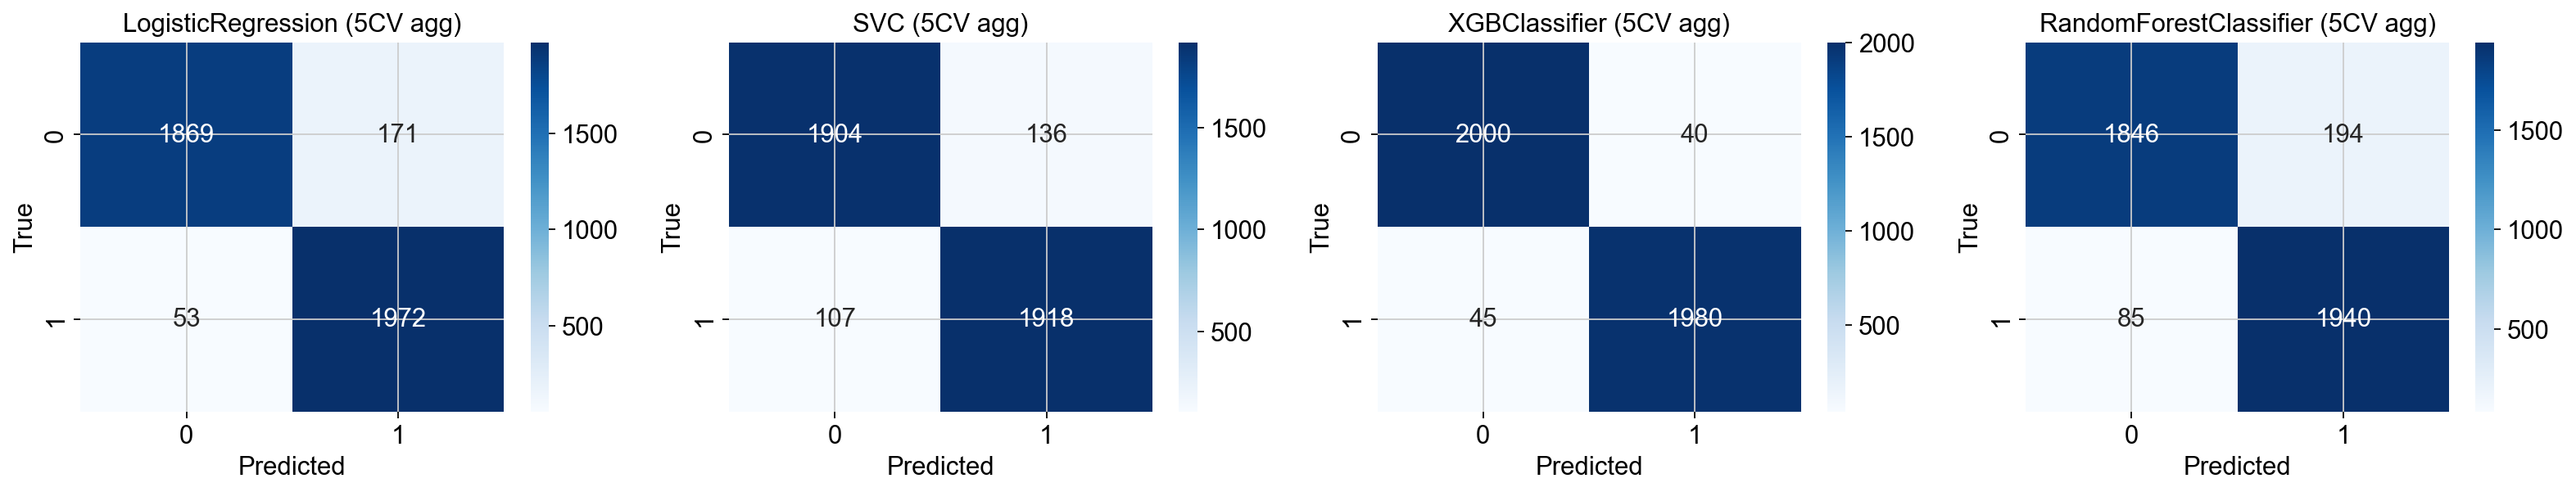

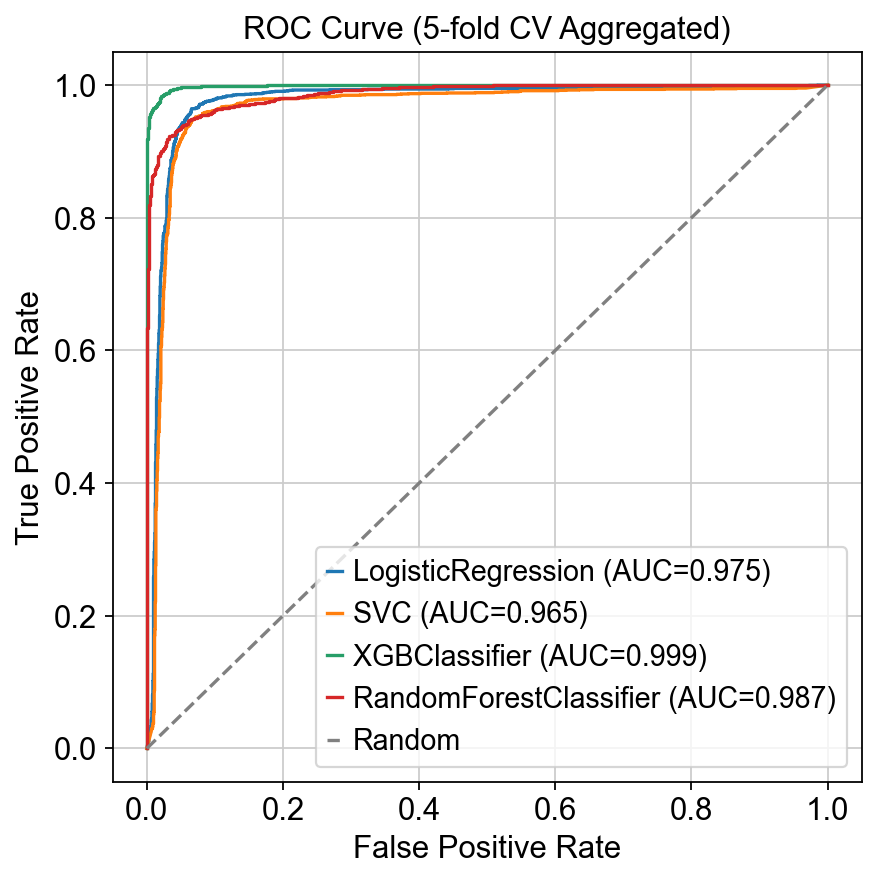

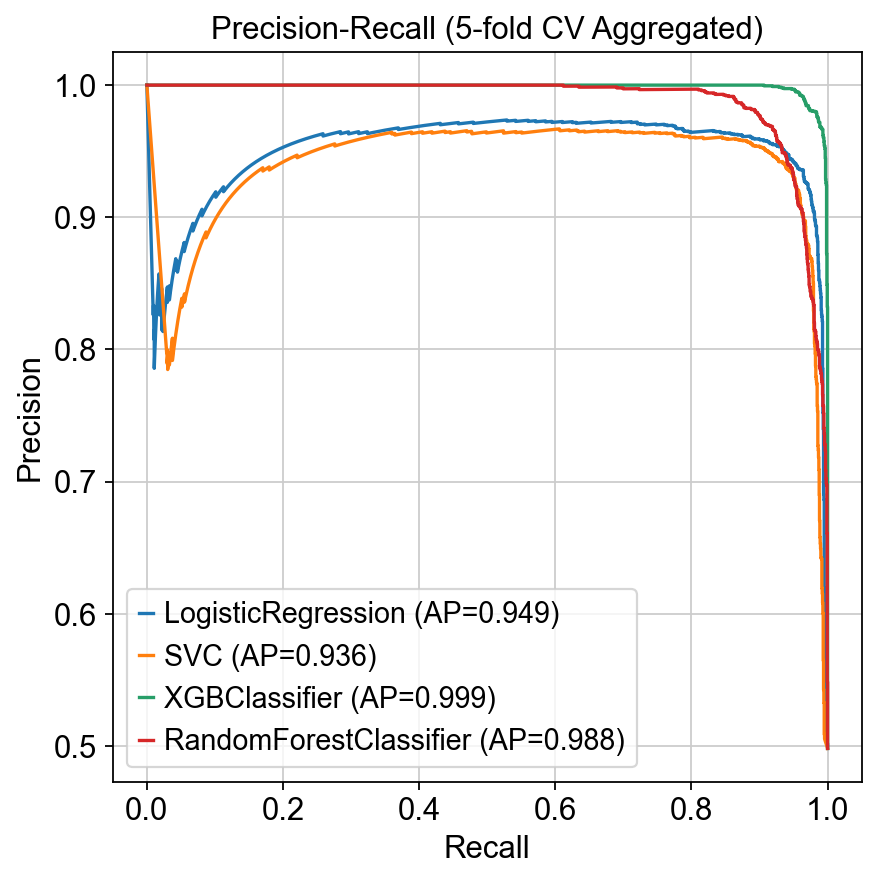

/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_2304/3660570094.py:275: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=final_df, x="Model", y="Acc", palette="viridis")


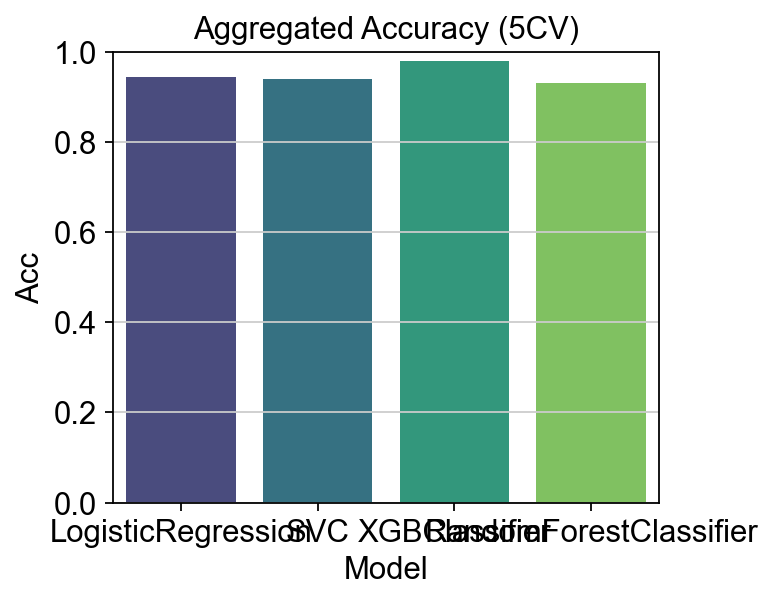

In [14]:
#!/usr/bin/env python

import os
import numpy as np
import pandas as pd

# Models & ML
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Utilities
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    roc_curve, precision_recall_curve, roc_auc_score,
    average_precision_score
)

import seaborn as sns
import matplotlib.pyplot as plt

# ========== A) Helper functions ==========

alias_to_official = {
    # Example gene alias map if you want to unify column names.
    # If not needed, you can remove unify_gene_symbols.
    "XIST": "Xist", "RPS27RT": "Rps27rt", "DDX3Y": "Ddx3y", "RPL35": "Rpl35",
    "EIF2S3Y": "Eif2s3y", "EIF2S3L": "Eif2s3y", "GM42418": "Gm42418", "UBA52": "Uba52",
    "RPL36A-PS1": "Rpl36a-ps1", "KDM5D": "Kdm5d", "JARID1D": "Kdm5d", "WDR89": "Wdr89",
    "UTY": "Uty", "LARS2": "Lars2", "AY036118": "AY036118", "RPL9-PS6": "Rpl9-ps6",
    "RPS27": "Rps27"
}

def unify_gene_symbols(df: pd.DataFrame) -> pd.DataFrame:
    """
    Case-insensitive alias→official; collapses duplicates by mean.
    If you don't need this step, you can remove it.
    """
    df = df.copy()
    # Map columns to official names if they appear in alias_to_official
    df.columns = [alias_to_official.get(c.upper(), c) for c in df.columns]
    # Collapse duplicates
    if df.columns.duplicated().any():
        df = df.groupby(df.columns, axis=1).mean()
    return df

def unify_labels(labels):
    """
    Convert label strings into numeric 0/1.
    Adjust the mapper if your CSV uses different encodings for 'male'/'female'.
    """
    mapper = {"f":0, "m":1, "female":0, "male":1, "0":0, "1":1, "0.0":0, "1.0":1}
    s = pd.Series(labels).astype(str).str.strip().str.lower().map(mapper)
    if s.isna().any():
        raise ValueError(f"Unrecognized labels: {s[s.isna()].unique()}")
    return s.astype(int)

# ========== B) Load entire dataset (No separate train/test) ==========

# 1) Read X, Y from your CSVs (adjust paths as needed)
X_full = pd.read_csv("X_extra_5_filtered.csv", index_col=0)
df_labels = pd.read_csv("Y_extra_5_filtered.csv", index_col=0, header=0)
y_full = df_labels["sex_label"]   # or whichever column name holds your labels

print("[INFO] Original X_full shape:", X_full.shape)
print("[INFO] Original y_full length:", len(y_full))

# 2) (Optional) unify gene symbols
X_full = unify_gene_symbols(X_full)
# 3) unify labels
y_full = unify_labels(y_full)

# 4) keep only matching rows
common_idx = X_full.index.intersection(y_full.index)
X_full = X_full.loc[common_idx].copy()
y_full = y_full.loc[common_idx].copy()

# remove duplicates if any
dup_mask = X_full.index.duplicated(keep="first")
if dup_mask.any():
    X_full = X_full[~dup_mask]
    y_full = y_full[~dup_mask]

print("[INFO] After intersection & dedup, X_full shape:", X_full.shape)
print("[INFO] y_full length:", len(y_full))

# ========== C) 5-Fold Stratified CV with Four Models ==========

models = [
    LogisticRegression(max_iter=1000, random_state=41),
    SVC(kernel="linear", probability=True, random_state=41),
    XGBClassifier(
        use_label_encoder=False, eval_metric='logloss',
        n_estimators=100, learning_rate=0.05, max_depth=10,
        random_state=41
    ),
    RandomForestClassifier(max_depth=10, random_state=41)
]
model_names = [m.__class__.__name__ for m in models]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=41)

# We'll collect feature importances each fold, plus predictions for final metrics
feature_importances = {m.__class__.__name__: [] for m in models}
fold_predictions = {m.__class__.__name__: {"y_true": [], "y_prob": []} for m in models}

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X_full, y_full), start=1):
    print(f"\n[INFO] Fold {fold_idx}/5")

    # Split
    X_tr = X_full.iloc[train_idx]
    X_te = X_full.iloc[test_idx]
    y_tr = y_full.iloc[train_idx]
    y_te = y_full.iloc[test_idx]

    # Scale
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_te_s = scaler.transform(X_te)

    # Train each model
    for model in models:
        mname = model.__class__.__name__
        model.fit(X_tr_s, y_tr)

        # Collect feature importances
        if hasattr(model, "coef_"):
            # Linear model: use absolute value of coefficients
            importances = np.abs(model.coef_[0])
        elif hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
        else:
            importances = np.zeros(X_tr.shape[1])

        df_imp = pd.DataFrame({
            "Feature": X_tr.columns,
            "Importance": importances
        })
        feature_importances[mname].append(df_imp)

        # Predict on this fold's test
        y_prob = model.predict_proba(X_te_s)[:, 1]
        # store
        fold_predictions[mname]["y_true"].extend(y_te.values)
        fold_predictions[mname]["y_prob"].extend(y_prob)


# ========== D) Aggregate Feature Importances & Save ==========

aggregated_importances = {}
os.makedirs("colon_feature", exist_ok=True)  # subdir for storing CSV

for mname, df_list in feature_importances.items():
    combined = pd.concat(df_list, ignore_index=True)
    # group by feature, get mean importance
    mean_imp = (combined.groupby("Feature")["Importance"]
                .mean()
                .reset_index()
                .sort_values("Importance", ascending=False)
                .reset_index(drop=True))
    mean_imp["Rank"] = mean_imp["Importance"].rank(
        method="dense", ascending=False
    ).astype(int)

    aggregated_importances[mname] = mean_imp
    outpath = os.path.join("colon_feature", f"{mname}_feature_importances.csv")
    mean_imp.to_csv(outpath, index=False)
    print(f"[INFO] Saved mean feature importances for {mname} → {outpath}")

# ========== E) Final Aggregated Metrics (pooled across folds) ==========

final_results = []

for model in models:
    mname = model.__class__.__name__

    y_true = np.array(fold_predictions[mname]["y_true"])
    y_prob = np.array(fold_predictions[mname]["y_prob"])
    y_pred = (y_prob >= 0.5).astype(int)

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    ap  = average_precision_score(y_true, y_prob)

    print(f"\n=== {mname} - Aggregated 5CV ===")
    print("Confusion Matrix:\n", cm)
    print(f"Accuracy={acc:.3f}, F1={f1:.3f}, AUROC={auc:.3f}, AUPRC={ap:.3f}")

    final_results.append({
        "Model":  mname,
        "Acc":    acc,
        "F1":     f1,
        "AUROC":  auc,
        "AUPRC":  ap
    })

final_df = pd.DataFrame(final_results)

# Create folder "colon" if not exists
os.makedirs("colon", exist_ok=True)

# Save final aggregated metrics as "colon/colon_generank.csv"
final_df.to_csv("colon/colon_generank.csv", index=False)
print("\n[INFO] Final aggregated metrics → colon/colon_generank.csv")
print(final_df)

# ========== F) Plot Confusion Matrix, ROC, PR (Aggregated) ==========

num_models = len(models)

# 1) Confusion matrices
fig_cm, axs_cm = plt.subplots(1, num_models, figsize=(5*num_models, 4))
if num_models == 1:
    axs_cm = [axs_cm]

for ax, model in zip(axs_cm, models):
    mname = model.__class__.__name__
    y_true = np.array(fold_predictions[mname]["y_true"])
    y_prob = np.array(fold_predictions[mname]["y_prob"])
    y_pred = (y_prob >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{mname} (5CV agg)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()

# 2) ROC curves
plt.figure(figsize=(6,6))
for model in models:
    mname = model.__class__.__name__
    y_true = np.array(fold_predictions[mname]["y_true"])
    y_prob = np.array(fold_predictions[mname]["y_prob"])

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)

    plt.plot(fpr, tpr, label=f"{mname} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],"--", color="gray", label="Random")
plt.title("ROC Curve (5-fold CV Aggregated)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# 3) Precision-Recall
plt.figure(figsize=(6,6))
for model in models:
    mname = model.__class__.__name__
    y_true = np.array(fold_predictions[mname]["y_true"])
    y_prob = np.array(fold_predictions[mname]["y_prob"])

    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)

    plt.plot(rec, prec, label=f"{mname} (AP={ap:.3f})")

plt.title("Precision-Recall (5-fold CV Aggregated)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

# 4) Bar plot of final Accuracy or other metric
plt.figure(figsize=(5,4))
sns.barplot(data=final_df, x="Model", y="Acc", palette="viridis")
plt.ylim(0,1)
plt.title("Aggregated Accuracy (5CV)")
plt.tight_layout()
plt.show()
